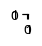

In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.multimodal_metrics import BSSVAELoss
from src.utils import get_class_initcode_keys
from src.multimodal_models import BSSVAE
from src.multimodal_train_eval import predict_multimodal, multimodal_train_eval_loops, train_multimodal_step, eval_multimodal_step
from src.multimodal_datasets import MultimodalPepTCRDataset, MultimodalCLFLatentDataset
from src.datasets import TwoStageTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180



def get_model(folder, **kwargs):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, **kwargs)
    return model
    

# XGBoost

In [6]:
from xgboost import XGBClassifier

In [7]:
%ls ../output/240404_TCRONLY_onetwostage_smallLARGE

240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_KFold_0_LARGETCRP1/
240404_1150_ExpData_TCRONLY_1stage_SMALL_128h_64l_NoTrp_KFold_0_smallTCRP1/
240404_1150_ExpData_TCRONLY_2stage_LARGE_256h_100l_NoTrp_KFold_0_2stTCRPLARGE/
240404_1150_ExpData_TCRONLY_2stage_SMALL_128h_64l_NoTrp_KFold_0_2stTCRPsmall/
240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_SmCosTCRP1/
240417_1515_BL62_ExpData_TCRONLY_2stage_LARGE_256h_100l_COSTrp_KFold_0_2stTCRPLARGE/
240417_1515_ExpData_TCRONLY_2stage_LARGE_256h_100l_COSTrp_KFold_0_2stTCRPLARGE/


In [39]:
# this uses paired only bss dataset
bss_addkldn = get_model('../output/240324_MMVAES/240325_AddAll_LongerEpochs/240325_1503_BSSVAE_ADDKLDN_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_hRmUHn/',
                       map_location='cpu')

# These use TCR only datasets
svae_notrp = get_model('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_KFold_0_LARGETCRP1/',
                      map_location='cpu')
svae_cos = get_model('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_SmCosTCRP1/',
                    map_location='cpu')
svae_reset = get_model('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_SmCosTCRP1/',
                    map_location='cpu')
print(svae_reset)
# this svae uses pep
svae_2stno = get_model('../output/240402_oldVAE_retrainedExpanded/240326_1639_240326_2stage_NoTrp_AddAll_ExpData_KFold_0_CCCCC/',
                      map_location='cpu').vae

Reloading best model:
epoch: 979
total: 0.24084176973443078
recon_marg: 0.052361211625974076
recon_joint: 0.05340298385659023
kld_marg: 4.560949089939287e-05
kld_joint: 0.13503195739777218
tcr_marg_seq_accuracy: 0.5249359607696533
tcr_joint_seq_accuracy: 0.5159700512886047
pep_joint_seq_accuracy: 0.802384078502655
pep_marg_seq_accuracy: 0.8112773895263672
wmean_seq_accuracy: 0.6063663244247437
Reloading best model:
Best epoch: 11925
total: 0.35566675662994385
reconstruction: 0.34581807255744934
kld: 0.009848671965301037
triplet: 0.0
seq_accuracy: 0.9893524050712585
pos_accuracy: 0.9996309280395508
Reloading best model:
Best epoch: 11882
total: 0.10637179474033316
reconstruction: 0.08248233795166016
kld: 0.0027784218546003103
triplet: 0.021111038426532353
seq_accuracy: 0.9905097484588623
pos_accuracy: 0.9976889491081238
Reloading best model:
Best epoch: 11882
total: 0.10637179474033316
reconstruction: 0.08248233795166016
kld: 0.0027784218546003103
triplet: 0.021111038426532353
seq_accur

In [3]:
from src.datasets import LatentTCRpMHCDataset
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from sklearn.metrics import roc_auc_score
new_df = pd.read_csv('../data/multimodal/240404_nettcr_swapped_no_original.csv')
old_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')

new_train = new_df.query('partition!=0')
new_valid = new_df.query('partition==0')

train_marg_dataset = MultimodalMarginalLatentDataset(bss_addkldn, new_train, pad_scale=-20, encoding='BL50LO', pep_encoding='BL50LO')
valid_marg_dataset = MultimodalMarginalLatentDataset(bss_addkldn, new_valid, pad_scale=-20, encoding='BL50LO', pep_encoding='BL50LO')


NameError: name 'bss_addkldn' is not defined

In [149]:
for n_est in [100, 200, 300]:
    for md in [5,7,9]:
        for lr in [0.1, 0.3, 0.7]:
            for mcw in np.linspace(0, 3, 10):
                mcw = round(mcw, 4)
                xgbclf = XGBClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, min_child_weight = mcw)
                xgbclf.fit(train_marg_dataset.z, train_marg_dataset.labels)
                train_pred = xgbclf.predict_proba(train_marg_dataset.z)[:, 1]
                valid_pred = xgbclf.predict_proba(valid_marg_dataset.z)[:, 1]
                train_auc = roc_auc_score(train_marg_dataset.labels, train_pred)
                valid_auc = roc_auc_score(valid_marg_dataset.labels, valid_pred)
                train_auc01 = roc_auc_score(train_marg_dataset.labels, train_pred, max_fpr=0.1)
                valid_auc01 = roc_auc_score(valid_marg_dataset.labels, valid_pred, max_fpr=0.1)
                print(f'{n_est} est,\t{md} max_depth,\t{lr} lr,\t{mcw} mcw')
                print(f'\tAUC:\t{round(train_auc, 4):.4f} tr,\t{round(valid_auc, 4):.4f} val')
                print(f'\tAUC_01:\t{round(train_auc01, 4):.4f} tr,\t{round(valid_auc01, 4):.4f} val')
                results.append({'vae':'bssvae_tcrMarginal','n_estimators':n_est, 'max_depth':md, 'lr':lr, 'mcw':mcw, 'train_auc':train_auc, 'train_auc01':train_auc01,
                                'valid_auc':valid_auc, 'valid_auc01':valid_auc01})

100 est,	5 max_depth,	0.1 lr,	0.0 mcw
	AUC:	0.9982 tr,	0.6894 val
	AUC_01:	0.9907 tr,	0.6085 val
100 est,	5 max_depth,	0.1 lr,	0.3333 mcw
	AUC:	0.9983 tr,	0.6887 val
	AUC_01:	0.9909 tr,	0.6097 val
100 est,	5 max_depth,	0.1 lr,	0.6667 mcw
	AUC:	0.9981 tr,	0.6789 val
	AUC_01:	0.9899 tr,	0.6077 val
100 est,	5 max_depth,	0.1 lr,	1.0 mcw
	AUC:	0.9981 tr,	0.6867 val
	AUC_01:	0.9899 tr,	0.6095 val
100 est,	5 max_depth,	0.1 lr,	1.3333 mcw
	AUC:	0.9980 tr,	0.6839 val
	AUC_01:	0.9895 tr,	0.6087 val
100 est,	5 max_depth,	0.1 lr,	1.6667 mcw
	AUC:	0.9984 tr,	0.6886 val
	AUC_01:	0.9913 tr,	0.6102 val
100 est,	5 max_depth,	0.1 lr,	2.0 mcw
	AUC:	0.9974 tr,	0.6757 val
	AUC_01:	0.9863 tr,	0.6066 val
100 est,	5 max_depth,	0.1 lr,	2.3333 mcw
	AUC:	0.9982 tr,	0.6821 val
	AUC_01:	0.9903 tr,	0.6115 val
100 est,	5 max_depth,	0.1 lr,	2.6667 mcw
	AUC:	0.9978 tr,	0.6881 val
	AUC_01:	0.9886 tr,	0.6093 val
100 est,	5 max_depth,	0.1 lr,	3.0 mcw
	AUC:	0.9976 tr,	0.6790 val
	AUC_01:	0.9874 tr,	0.6094 val
100 est,	5 m

In [43]:
print(svae_reset.encoder[0].weight[0, :5])
svae_reset.reset_parameters()
print(svae_reset.encoder[0].weight[0, :5])

tensor([-3.6693e-14, -1.5284e-14,  3.2444e-14,  1.0279e-13, -5.1256e-14],
       grad_fn=<SliceBackward0>)
tensor([-0.0175,  0.0019,  0.0020,  0.0010, -0.0052], grad_fn=<SliceBackward0>)


In [4]:
new_df = pd.read_csv('../data/multimodal/240404_nettcr_swapped_no_original.csv')
old_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')

new_train = new_df.query('partition!=0')
new_valid = new_df.query('partition==0')

In [44]:
from src.datasets import LatentTCRpMHCDataset
from src.multimodal_datasets import MultimodalCLFLatentDataset
from sklearn.metrics import roc_auc_score

train_bss_dataset = MultimodalCLFLatentDataset(bss_addkldn, new_train, pad_scale=-20, encoding='BL50LO', pep_encoding='BL50LO')
train_tcrnotrp_dataset = LatentTCRpMHCDataset(svae_notrp, new_train, 7,8,22,6,7,23, add_positional_encoding=True)
train_tcrcos_dataset = LatentTCRpMHCDataset(svae_cos, new_train, 7,8,22,6,7,23, add_positional_encoding=True)
train_tcr2st_dataset = LatentTCRpMHCDataset(svae_2stno, new_train, 7,8,22,6,7,23,12, add_positional_encoding=False)

valid_bss_dataset = MultimodalCLFLatentDataset(bss_addkldn, new_valid, pad_scale=-20, encoding='BL50LO', pep_encoding='BL50LO')
valid_tcrnotrp_dataset = LatentTCRpMHCDataset(svae_notrp, new_valid, 7,8,22,6,7,23, add_positional_encoding=True)
valid_tcrcos_dataset = LatentTCRpMHCDataset(svae_cos, new_valid, 7,8,22,6,7,23, add_positional_encoding=True)
valid_tcr2st_dataset = LatentTCRpMHCDataset(svae_2stno, new_valid, 7,8,22,6,7,23,12, add_positional_encoding=False)

train_reset_dataset = LatentTCRpMHCDataset(svae_reset, new_train, 7,8,22,6,7,23, add_positional_encoding=True)
valid_reset_dataset = LatentTCRpMHCDataset(svae_reset, new_valid, 7,8,22,6,7,23, add_positional_encoding=True)


PEPWEIGHTED False
PEPWEIGHTED False


In [37]:
results = []

In [45]:
for n_est in [100, 200, 300]:
    for md in [5,7,9]:
        for lr in [0.1, 0.3, 0.7]:
            for mcw in np.linspace(0, 3, 10):
                mcw = round(mcw, 4)
                xgbclf = XGBClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, min_child_weight = mcw)
                xgbclf.fit(train_tcr2st_dataset.x, train_tcr2st_dataset.labels)
                train_pred = xgbclf.predict_proba(train_tcr2st_dataset.x)[:, 1]
                valid_pred = xgbclf.predict_proba(valid_tcr2st_dataset.x)[:, 1]
                train_auc = roc_auc_score(train_tcr2st_dataset.labels, train_pred)
                valid_auc = roc_auc_score(valid_tcr2st_dataset.labels, valid_pred)
                train_auc01 = roc_auc_score(train_tcr2st_dataset.labels, train_pred, max_fpr=0.1)
                valid_auc01 = roc_auc_score(valid_tcr2st_dataset.labels, valid_pred, max_fpr=0.1)
                print(f'{n_est} est,\t{md} max_depth,\t{lr} lr,\t{mcw} mcw')
                print(f'\tAUC:\t{round(train_auc, 4):.4f} tr,\t{round(valid_auc, 4):.4f} val')
                print(f'\tAUC_01:\t{round(train_auc01, 4):.4f} tr,\t{round(valid_auc01, 4):.4f} val')
                results.append({'vae':'2stage_notriplet','n_estimators':n_est, 'max_depth':md, 'lr':lr, 'mcw':mcw, 'train_auc':train_auc, 'train_auc01':train_auc01,
                                'valid_auc':valid_auc, 'valid_auc01':valid_auc01})

100 est,	5 max_depth,	0.1 lr,	0.0 mcw
	AUC:	0.9032 tr,	0.7094 val
	AUC_01:	0.7752 tr,	0.6125 val
100 est,	5 max_depth,	0.1 lr,	0.3333 mcw
	AUC:	0.9008 tr,	0.7137 val
	AUC_01:	0.7734 tr,	0.6177 val
100 est,	5 max_depth,	0.1 lr,	0.6667 mcw
	AUC:	0.9025 tr,	0.7184 val
	AUC_01:	0.7757 tr,	0.6157 val
100 est,	5 max_depth,	0.1 lr,	1.0 mcw
	AUC:	0.9026 tr,	0.7131 val
	AUC_01:	0.7737 tr,	0.6141 val
100 est,	5 max_depth,	0.1 lr,	1.3333 mcw
	AUC:	0.8996 tr,	0.7142 val
	AUC_01:	0.7718 tr,	0.6142 val
100 est,	5 max_depth,	0.1 lr,	1.6667 mcw
	AUC:	0.8990 tr,	0.7130 val
	AUC_01:	0.7703 tr,	0.6167 val
100 est,	5 max_depth,	0.1 lr,	2.0 mcw
	AUC:	0.8989 tr,	0.7159 val
	AUC_01:	0.7681 tr,	0.6149 val
100 est,	5 max_depth,	0.1 lr,	2.3333 mcw
	AUC:	0.8945 tr,	0.7103 val
	AUC_01:	0.7642 tr,	0.6125 val
100 est,	5 max_depth,	0.1 lr,	2.6667 mcw
	AUC:	0.8968 tr,	0.7151 val
	AUC_01:	0.7658 tr,	0.6164 val
100 est,	5 max_depth,	0.1 lr,	3.0 mcw
	AUC:	0.8992 tr,	0.7128 val
	AUC_01:	0.7688 tr,	0.6123 val
100 est,	5 m

In [46]:
for n_est in [100, 200, 300]:
    for md in [5,7,9]:
        for lr in [0.1, 0.3, 0.7]:
            for mcw in np.linspace(0, 3, 10):
                mcw = round(mcw, 4)
                xgbclf = XGBClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, min_child_weight = mcw)
                xgbclf.fit(train_reset_dataset.x, train_reset_dataset.labels)
                train_pred = xgbclf.predict_proba(train_reset_dataset.x)[:, 1]
                valid_pred = xgbclf.predict_proba(valid_reset_dataset.x)[:, 1]
                train_auc = roc_auc_score(train_reset_dataset.labels, train_pred)
                valid_auc = roc_auc_score(valid_reset_dataset.labels, valid_pred)
                train_auc01 = roc_auc_score(train_reset_dataset.labels, train_pred, max_fpr=0.1)
                valid_auc01 = roc_auc_score(valid_reset_dataset.labels, valid_pred, max_fpr=0.1)
                print(f'{n_est} est,\t{md} max_depth,\t{lr} lr,\t{mcw} mcw')
                print(f'\tAUC:\t{round(train_auc, 4):.4f} tr,\t{round(valid_auc, 4):.4f} val')
                print(f'\tAUC_01:\t{round(train_auc01, 4):.4f} tr,\t{round(valid_auc01, 4):.4f} val')
                results.append({'vae':'reset','n_estimators':n_est, 'max_depth':md, 'lr':lr, 'mcw':mcw, 'train_auc':train_auc, 'train_auc01':train_auc01,
                                'valid_auc':valid_auc, 'valid_auc01':valid_auc01})

100 est,	5 max_depth,	0.1 lr,	0.0 mcw
	AUC:	0.8595 tr,	0.6856 val
	AUC_01:	0.7168 tr,	0.5952 val
100 est,	5 max_depth,	0.1 lr,	0.3333 mcw
	AUC:	0.8622 tr,	0.6923 val
	AUC_01:	0.7195 tr,	0.5968 val
100 est,	5 max_depth,	0.1 lr,	0.6667 mcw
	AUC:	0.8575 tr,	0.6887 val
	AUC_01:	0.7130 tr,	0.5998 val
100 est,	5 max_depth,	0.1 lr,	1.0 mcw
	AUC:	0.8567 tr,	0.6868 val
	AUC_01:	0.7126 tr,	0.5980 val
100 est,	5 max_depth,	0.1 lr,	1.3333 mcw
	AUC:	0.8540 tr,	0.6919 val
	AUC_01:	0.7135 tr,	0.5981 val
100 est,	5 max_depth,	0.1 lr,	1.6667 mcw
	AUC:	0.8586 tr,	0.6913 val
	AUC_01:	0.7138 tr,	0.5998 val
100 est,	5 max_depth,	0.1 lr,	2.0 mcw
	AUC:	0.8566 tr,	0.6874 val
	AUC_01:	0.7138 tr,	0.5976 val
100 est,	5 max_depth,	0.1 lr,	2.3333 mcw
	AUC:	0.8540 tr,	0.6938 val
	AUC_01:	0.7106 tr,	0.5974 val
100 est,	5 max_depth,	0.1 lr,	2.6667 mcw
	AUC:	0.8525 tr,	0.6885 val
	AUC_01:	0.7079 tr,	0.5961 val
100 est,	5 max_depth,	0.1 lr,	3.0 mcw
	AUC:	0.8503 tr,	0.6818 val
	AUC_01:	0.7078 tr,	0.5975 val
100 est,	5 m

In [47]:
for n_est in [100, 200, 300]:
    for md in [5,7,9]:
        for lr in [0.1, 0.3, 0.7]:
            for mcw in np.linspace(0, 3, 10):
                mcw = round(mcw, 4)
                xgbclf = XGBClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, min_child_weight = mcw)
                xgbclf.fit(train_tcrnotrp_dataset.x, train_tcrnotrp_dataset.labels)
                train_pred = xgbclf.predict_proba(train_tcrnotrp_dataset.x)[:, 1]
                valid_pred = xgbclf.predict_proba(valid_tcrnotrp_dataset.x)[:, 1]
                train_auc = roc_auc_score(train_tcrnotrp_dataset.labels, train_pred)
                valid_auc = roc_auc_score(valid_tcrnotrp_dataset.labels, valid_pred)
                train_auc01 = roc_auc_score(train_tcrnotrp_dataset.labels, train_pred, max_fpr=0.1)
                valid_auc01 = roc_auc_score(valid_tcrnotrp_dataset.labels, valid_pred, max_fpr=0.1)
                print(f'{n_est} est,\t{md} max_depth,\t{lr} lr,\t{mcw} mcw')
                print(f'\tAUC:\t{round(train_auc, 4):.4f} tr,\t{round(valid_auc, 4):.4f} val')
                print(f'\tAUC_01:\t{round(train_auc01, 4):.4f} tr,\t{round(valid_auc01, 4):.4f} val')
                results.append({'vae':'1stage_notriplet','n_estimators':n_est, 'max_depth':md, 'lr':lr, 'mcw':mcw, 'train_auc':train_auc, 'train_auc01':train_auc01,
                                'valid_auc':valid_auc, 'valid_auc01':valid_auc01})

100 est,	5 max_depth,	0.1 lr,	0.0 mcw
	AUC:	0.8757 tr,	0.6812 val
	AUC_01:	0.7407 tr,	0.5951 val
100 est,	5 max_depth,	0.1 lr,	0.3333 mcw
	AUC:	0.8794 tr,	0.6823 val
	AUC_01:	0.7459 tr,	0.5926 val
100 est,	5 max_depth,	0.1 lr,	0.6667 mcw
	AUC:	0.8758 tr,	0.6784 val
	AUC_01:	0.7366 tr,	0.5908 val
100 est,	5 max_depth,	0.1 lr,	1.0 mcw
	AUC:	0.8759 tr,	0.6854 val
	AUC_01:	0.7374 tr,	0.5901 val
100 est,	5 max_depth,	0.1 lr,	1.3333 mcw
	AUC:	0.8749 tr,	0.6799 val
	AUC_01:	0.7416 tr,	0.5946 val
100 est,	5 max_depth,	0.1 lr,	1.6667 mcw
	AUC:	0.8746 tr,	0.6814 val
	AUC_01:	0.7386 tr,	0.5898 val
100 est,	5 max_depth,	0.1 lr,	2.0 mcw
	AUC:	0.8763 tr,	0.6809 val
	AUC_01:	0.7403 tr,	0.5936 val
100 est,	5 max_depth,	0.1 lr,	2.3333 mcw
	AUC:	0.8755 tr,	0.6840 val
	AUC_01:	0.7402 tr,	0.5938 val
100 est,	5 max_depth,	0.1 lr,	2.6667 mcw
	AUC:	0.8757 tr,	0.6830 val
	AUC_01:	0.7361 tr,	0.5971 val
100 est,	5 max_depth,	0.1 lr,	3.0 mcw
	AUC:	0.8693 tr,	0.6860 val
	AUC_01:	0.7302 tr,	0.5958 val
100 est,	5 m

In [48]:
for n_est in [100, 200, 300]:
    for md in [5,7,9]:
        for lr in [0.1, 0.3, 0.7]:
            for mcw in np.linspace(0, 3, 10):
                mcw = round(mcw, 4)
                xgbclf = XGBClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, min_child_weight = mcw)
                xgbclf.fit(train_tcrcos_dataset.x, train_tcrcos_dataset.labels)
                train_pred = xgbclf.predict_proba(train_tcrcos_dataset.x)[:, 1]
                valid_pred = xgbclf.predict_proba(valid_tcrcos_dataset.x)[:, 1]
                train_auc = roc_auc_score(train_tcrcos_dataset.labels, train_pred)
                valid_auc = roc_auc_score(valid_tcrcos_dataset.labels, valid_pred)
                train_auc01 = roc_auc_score(train_tcrcos_dataset.labels, train_pred, max_fpr=0.1)
                valid_auc01 = roc_auc_score(valid_tcrcos_dataset.labels, valid_pred, max_fpr=0.1)
                print(f'{n_est} est,\t{md} max_depth,\t{lr} lr,\t{mcw} mcw')
                print(f'\tAUC:\t{round(train_auc, 4)} tr,\t{round(valid_auc, 4)} val')
                print(f'\tAUC_01:\t{round(train_auc01, 4)} tr,\t{round(valid_auc01, 4)} val')
                results.append({'vae':'1stage_COStriplet','n_estimators':n_est, 'max_depth':md, 'lr':lr, 'mcw':mcw, 'train_auc':train_auc, 'train_auc01':train_auc01,
                                'valid_auc':valid_auc, 'valid_auc01':valid_auc01})

100 est,	5 max_depth,	0.1 lr,	0.0 mcw
	AUC:	0.8897 tr,	0.696 val
	AUC_01:	0.7578 tr,	0.6014 val
100 est,	5 max_depth,	0.1 lr,	0.3333 mcw
	AUC:	0.8876 tr,	0.6931 val
	AUC_01:	0.7546 tr,	0.6018 val
100 est,	5 max_depth,	0.1 lr,	0.6667 mcw
	AUC:	0.8873 tr,	0.698 val
	AUC_01:	0.7521 tr,	0.6 val
100 est,	5 max_depth,	0.1 lr,	1.0 mcw
	AUC:	0.8858 tr,	0.6863 val
	AUC_01:	0.7546 tr,	0.5999 val
100 est,	5 max_depth,	0.1 lr,	1.3333 mcw
	AUC:	0.8897 tr,	0.6913 val
	AUC_01:	0.7581 tr,	0.6057 val
100 est,	5 max_depth,	0.1 lr,	1.6667 mcw
	AUC:	0.8859 tr,	0.6951 val
	AUC_01:	0.7505 tr,	0.6028 val
100 est,	5 max_depth,	0.1 lr,	2.0 mcw
	AUC:	0.8812 tr,	0.694 val
	AUC_01:	0.7428 tr,	0.6017 val
100 est,	5 max_depth,	0.1 lr,	2.3333 mcw
	AUC:	0.8866 tr,	0.6992 val
	AUC_01:	0.7526 tr,	0.6061 val
100 est,	5 max_depth,	0.1 lr,	2.6667 mcw
	AUC:	0.8854 tr,	0.6948 val
	AUC_01:	0.7513 tr,	0.6014 val
100 est,	5 max_depth,	0.1 lr,	3.0 mcw
	AUC:	0.8824 tr,	0.6895 val
	AUC_01:	0.7471 tr,	0.6023 val
100 est,	5 max_dep

In [52]:
len(train_bss_dataset.x)

10

In [53]:
for n_est in [100, 200, 300]:
    for md in [5,7,9]:
        for lr in [0.1, 0.3, 0.7]:
            for mcw in np.linspace(0, 3, 10):
                mcw = round(mcw, 4)
                xgbclf = XGBClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, min_child_weight = mcw)
                xgbclf.fit(train_bss_dataset.z, train_bss_dataset.labels)
                train_pred = xgbclf.predict_proba(train_bss_dataset.z)[:, 1]
                valid_pred = xgbclf.predict_proba(valid_bss_dataset.z)[:, 1]
                train_auc = roc_auc_score(train_bss_dataset.labels, train_pred)
                valid_auc = roc_auc_score(valid_bss_dataset.labels, valid_pred)
                train_auc01 = roc_auc_score(train_bss_dataset.labels, train_pred, max_fpr=0.1)
                valid_auc01 = roc_auc_score(valid_bss_dataset.labels, valid_pred, max_fpr=0.1)
                print(f'{n_est} est,\t{md} max_depth,\t{lr} lr,\t{mcw} mcw')
                print(f'\tAUC:\t{round(train_auc, 4):.4f} tr,\t{round(valid_auc, 4):.4f} val')
                print(f'\tAUC_01:\t{round(train_auc01, 4):.4f} tr,\t{round(valid_auc01, 4):.4f} val')
                results.append({'vae':'bssvae_addkldn','n_estimators':n_est, 'max_depth':md, 'lr':lr, 'mcw':mcw, 'train_auc':train_auc, 'train_auc01':train_auc01,
                                'valid_auc':valid_auc, 'valid_auc01':valid_auc01})

100 est,	5 max_depth,	0.1 lr,	0.0 mcw
	AUC:	0.8653 tr,	0.7418 val
	AUC_01:	0.7355 tr,	0.6348 val
100 est,	5 max_depth,	0.1 lr,	0.3333 mcw
	AUC:	0.8640 tr,	0.7420 val
	AUC_01:	0.7329 tr,	0.6318 val
100 est,	5 max_depth,	0.1 lr,	0.6667 mcw
	AUC:	0.8614 tr,	0.7391 val
	AUC_01:	0.7338 tr,	0.6320 val
100 est,	5 max_depth,	0.1 lr,	1.0 mcw
	AUC:	0.8617 tr,	0.7413 val
	AUC_01:	0.7298 tr,	0.6320 val
100 est,	5 max_depth,	0.1 lr,	1.3333 mcw
	AUC:	0.8559 tr,	0.7366 val
	AUC_01:	0.7288 tr,	0.6298 val
100 est,	5 max_depth,	0.1 lr,	1.6667 mcw
	AUC:	0.8590 tr,	0.7377 val
	AUC_01:	0.7308 tr,	0.6306 val
100 est,	5 max_depth,	0.1 lr,	2.0 mcw
	AUC:	0.8569 tr,	0.7368 val
	AUC_01:	0.7249 tr,	0.6287 val
100 est,	5 max_depth,	0.1 lr,	2.3333 mcw
	AUC:	0.8552 tr,	0.7379 val
	AUC_01:	0.7238 tr,	0.6283 val
100 est,	5 max_depth,	0.1 lr,	2.6667 mcw
	AUC:	0.8558 tr,	0.7395 val
	AUC_01:	0.7220 tr,	0.6306 val
100 est,	5 max_depth,	0.1 lr,	3.0 mcw
	AUC:	0.8551 tr,	0.7356 val
	AUC_01:	0.7232 tr,	0.6300 val
100 est,	5 m

In [234]:
resdf = pd.DataFrame(results)
display(resdf.sort_values('valid_auc',ascending=False).head(5))
display(resdf.sort_values('valid_auc01',ascending=False).head(5))

,vae,n_estimators,max_depth,lr,mcw,train_auc,train_auc01,valid_auc,valid_auc01
1445,bssvae_addkldn,300,9,0.1,3.0000,0.999856,0.999244,0.771523,0.656755
1355,bssvae_addkldn,200,9,0.1,3.0000,0.998035,0.991251,0.769402,0.653746
1442,bssvae_addkldn,300,9,0.1,2.0000,0.999954,0.999759,0.769231,0.657148
1352,bssvae_addkldn,200,9,0.1,2.0000,0.998971,0.995048,0.768938,0.654292
1441,bssvae_addkldn,300,9,0.1,1.6667,0.999967,0.999827,0.768291,0.653238


,vae,n_estimators,max_depth,lr,mcw,train_auc,train_auc01,valid_auc,valid_auc01
1442,bssvae_addkldn,300,9,0.1,2.0000,0.999954,0.999759,0.769231,0.657148
1445,bssvae_addkldn,300,9,0.1,3.0000,0.999856,0.999244,0.771523,0.656755
1440,bssvae_addkldn,300,9,0.1,1.3333,0.999980,0.999893,0.764734,0.655722
1454,bssvae_addkldn,300,9,0.3,2.6667,1.000000,1.000000,0.755691,0.654469
1352,bssvae_addkldn,200,9,0.1,2.0000,0.998971,0.995048,0.768938,0.654292


In [60]:
resdf.query('not vae.str.contains("bss")').sort_values('valid_auc01',ascending=False)

,vae,n_estimators,max_depth,lr,mcw,train_auc,train_auc01,valid_auc,valid_auc01
1176,1stage_COStriplet,300,9,0.3,0.0000,1.000000,1.000000,0.752618,0.653081
896,1stage_notriplet,300,9,0.1,0.0000,0.999998,0.999991,0.749030,0.651138
1177,1stage_COStriplet,300,9,0.3,0.3333,1.000000,1.000000,0.753553,0.650179
359,2stage_notriplet,300,9,0.1,1.0000,1.000000,1.000000,0.761973,0.648863
356,2stage_notriplet,300,9,0.1,0.0000,1.000000,1.000000,0.763433,0.647935
...,...,...,...,...,...,...,...,...,...
682,1stage_notriplet,100,5,0.7,2.0000,0.964632,0.892466,0.683960,0.578981
411,reset,100,5,0.7,1.6667,0.950680,0.862800,0.689794,0.578564
680,1stage_notriplet,100,5,0.7,1.3333,0.962799,0.892097,0.689897,0.578024
678,1stage_notriplet,100,5,0.7,0.6667,0.968196,0.902251,0.682853,0.577390


In [235]:
def get_best_n(df, col='valid_auc01', n=3):
    return df.sort_values(col, ascending=False).head(n)

resdf.groupby('vae').apply(get_best_n, col='valid_auc01', n=1)

,,vae,n_estimators,max_depth,lr,mcw,train_auc,train_auc01,valid_auc,valid_auc01
vae,,,,,,,,,,
1stage_COStriplet,1176,1stage_COStriplet,300,9,0.3,0.0,1.000000,1.000000,0.752618,0.653081
1stage_notriplet,896,1stage_notriplet,300,9,0.1,0.0,0.999998,0.999991,0.749030,0.651138
2stage_notriplet,359,2stage_notriplet,300,9,0.1,1.0,1.000000,1.000000,0.761973,0.648863
bssvae_addkldn,1442,bssvae_addkldn,300,9,0.1,2.0,0.999954,0.999759,0.769231,0.657148
bssvae_tcrMarginal,1595,bssvae_tcrMarginal,200,7,0.1,3.0,0.999985,0.999922,0.696879,0.614521
reset,626,reset,300,9,0.1,0.0,0.999939,0.999679,0.741140,0.642452


In [259]:
min20 = new_df.query('binder==1').groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).query('count>=20').index
to_save=new_df.query('peptide in @min20 and binder==1').reset_index(drop=True)
print(len(to_save))
to_save.to_csv('../data/filtered/240410_NetTCR_expanded_min20binders_with_10x.csv', index=False)

8870


In [260]:
min20 = new_df.query('binder==1 and origin!="10x"').groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).query('count>=20').index
to_save = new_df.query('peptide in @min20 and binder==1 and origin!="10x"').reset_index(drop=True)
print(len(to_save))

to_save.to_csv('../data/filtered/240410_NetTCR_expanded_min20binders_NO_10x.csv', index=False)

4624


In [264]:
%ls ../data/filtered/*26*

../data/filtered/231205_nettcr_old_26pep_with_swaps.csv


In [257]:
%ls -lh ../data/filtered/*240410*

-rw-r--r--  1 riwa  staff   638K Apr 10 22:36 ../data/filtered/240410_NetTCR_expanded_min20binders_NO_10x.csv
-rw-r--r--  1 riwa  staff   1.1M Apr 10 22:36 ../data/filtered/240410_NetTCR_expanded_min20binders_with_10x.csv


In [245]:
old_df.query('binder==1').groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).head(25)

,count
peptide,
GILGFVFTL,1125
RAKFKQLL,934
KLGGALQAK,902
AVFDRKSDAK,716
ELAGIGILTV,426
NLVPMVATV,330
IVTDFSVIK,308
LLWNGPMAV,229
CINGVCWTV,226


In [236]:
resdf.to_csv('../output/240410_XGBoost/vae_xgboost_tune_results.csv')

## Get a untrained 3layer nn.Sequential (like the TCR encoder structure) as input after TCRBlosum

In [295]:
# Am I doing something wrong?
from src.multimodal_datasets import _encode_chains
# Reading data and partitioning
df = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv')
reset_train_df = df.query('partition!=0')
reset_valid_df = df.query('partition==0')
# Encoding the TCR chains with BLOSUM 50 LogOdds
x_train = _encode_chains(reset_train_df, 'BL50LO', -20, 'A1','A2','A3','B1','B2','B3', 'peptide', 7,8,22,6,7,23,12)[1].flatten(start_dim=1)
x_valid = _encode_chains(reset_valid_df, 'BL50LO', -20, 'A1','A2','A3','B1','B2','B3', 'peptide', 7,8,22,6,7,23,12)[1].flatten(start_dim=1)
# Creating a new set of layers from scratch
# (which is equal to the encoder in my VAE, except no BatchNorm here) 
untrained_layers = nn.Sequential(*[nn.Linear(1700, 1700//2), nn.SELU(), nn.Linear(1700//2, 256), nn.SELU(), 
                                  nn.Linear(256, 256), nn.SELU(), nn.Linear(256, 100)])
untrained_layers.eval()
# "extract" z with the layers
with torch.no_grad():
    z_valid = untrained_layers(x_valid).detach().cpu()
    z_train = untrained_layers(x_train).detach().cpu()
# Get the labels
y_train = reset_train_df['binder'].values
y_valid = reset_valid_df['binder'].values
# Create a new XGBoost model instance, fit on train and predict on valid
xgb_reset = XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.1, min_child_weight=3)
xgb_reset.fit(z_train, y_train)
valid_pred_reset = xgb_reset.predict_proba(z_valid)


Text(0.5, 1.0, 'Trained on the expanded (170 peps) dataset\nAUC=0.6681, AUC01=0.6234')

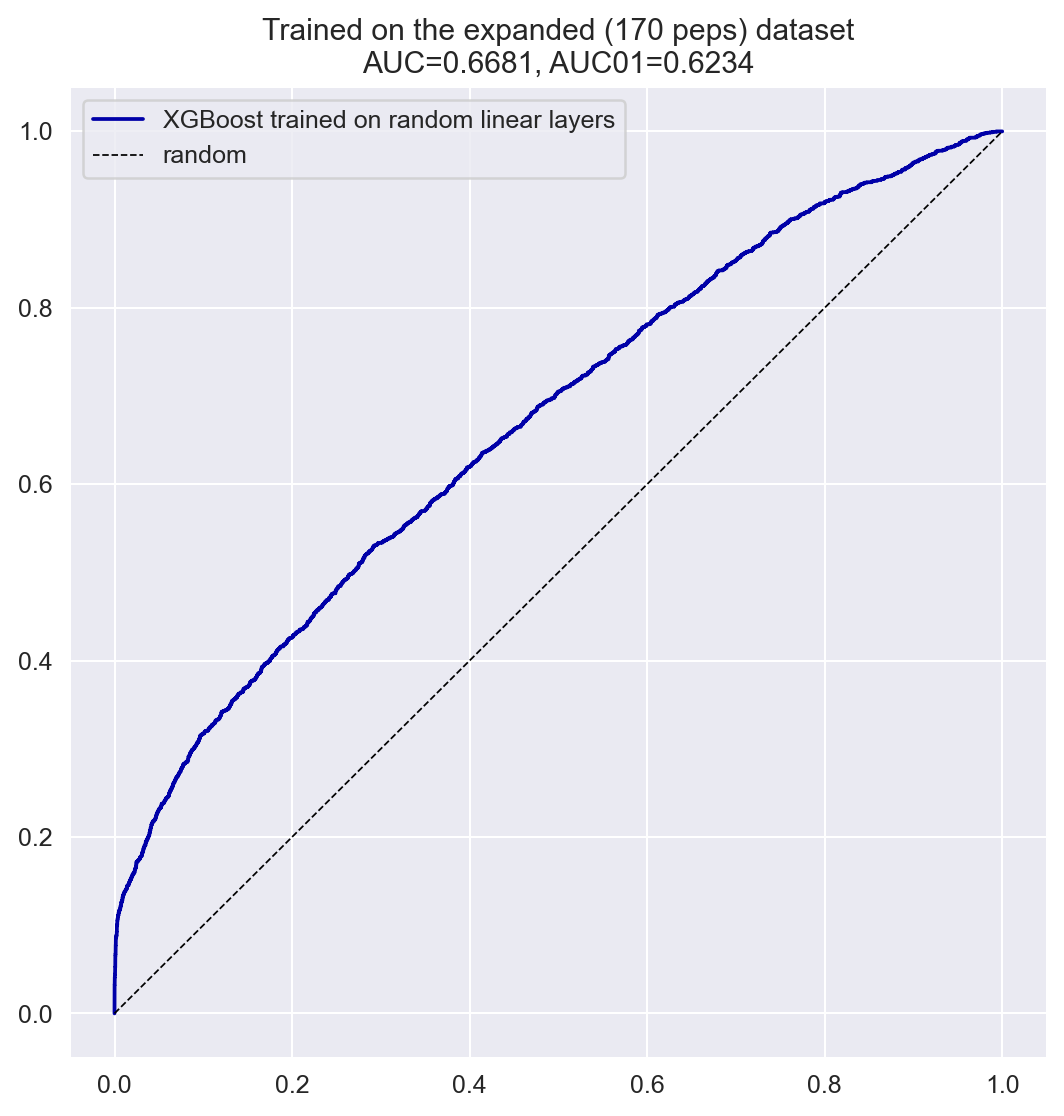

In [296]:
from sklearn.metrics import roc_curve
auc = roc_auc_score(y_valid, valid_pred_reset[:, 1])
auc_01 = roc_auc_score(y_valid, valid_pred_reset[:, 1], max_fpr=0.1)
fpr, tpr, _ = roc_curve(y_valid, valid_pred_reset[:, 1])
f,a = plt.subplots(1,1, figsize=(7,7))
a.plot(fpr, tpr, label='XGBoost trained on random linear layers')
a.plot([0,1], [0,1], label='random', ls='--', lw=0.7, c='k')
a.legend()
a.set_title(f'Trained on the expanded (170 peps) dataset\nAUC={auc:.4f}, AUC01={auc01:.4f}')

In [305]:
len(new_df)

58614

In [306]:
from src.data_processing import encoding_matrix_dict
pkl_dump(encoding_matrix_dict, './encoding_matrix_dict.pkl')

/Users/riwa/Documents/code/tclustr/notebooks/encoding_matrix_dict.pkl saved.


In [304]:
len(pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv'))


58614

In [297]:
# Am I doing something wrong?
from src.multimodal_datasets import _encode_chains
# Reading data and partitioning
df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')
reset_train_df = df.query('partition!=0')
reset_valid_df = df.query('partition==0')
# Encoding the TCR chains with BLOSUM 50 LogOdds
x_train = _encode_chains(reset_train_df, 'BL50LO', -20, 'A1','A2','A3','B1','B2','B3', 'peptide', 7,8,22,6,7,23,12)[1].flatten(start_dim=1)
x_valid = _encode_chains(reset_valid_df, 'BL50LO', -20, 'A1','A2','A3','B1','B2','B3', 'peptide', 7,8,22,6,7,23,12)[1].flatten(start_dim=1)
# Creating a new set of layers from scratch
# (which is equal to the encoder in my VAE, except no BatchNorm here) 
untrained_layers = nn.Sequential(*[nn.Linear(1700, 1700//2), nn.SELU(), nn.Linear(1700//2, 256), nn.SELU(), 
                                  nn.Linear(256, 256), nn.SELU(), nn.Linear(256, 100)])
untrained_layers.eval()
# "extract" z with the layers
with torch.no_grad():
    z_valid = untrained_layers(x_valid).detach().cpu()
    z_train = untrained_layers(x_train).detach().cpu()
# Get the labels
y_train = reset_train_df['binder'].values
y_valid = reset_valid_df['binder'].values
# Create a new XGBoost model instance, fit on train and predict on valid
xgb_reset = XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.1, min_child_weight=3)
xgb_reset.fit(z_train, y_train)
valid_pred_reset = xgb_reset.predict_proba(z_valid)


Text(0.5, 1.0, 'Trained on the old (26peps) dataset\nAUC=0.7010, AUC01=0.6234')

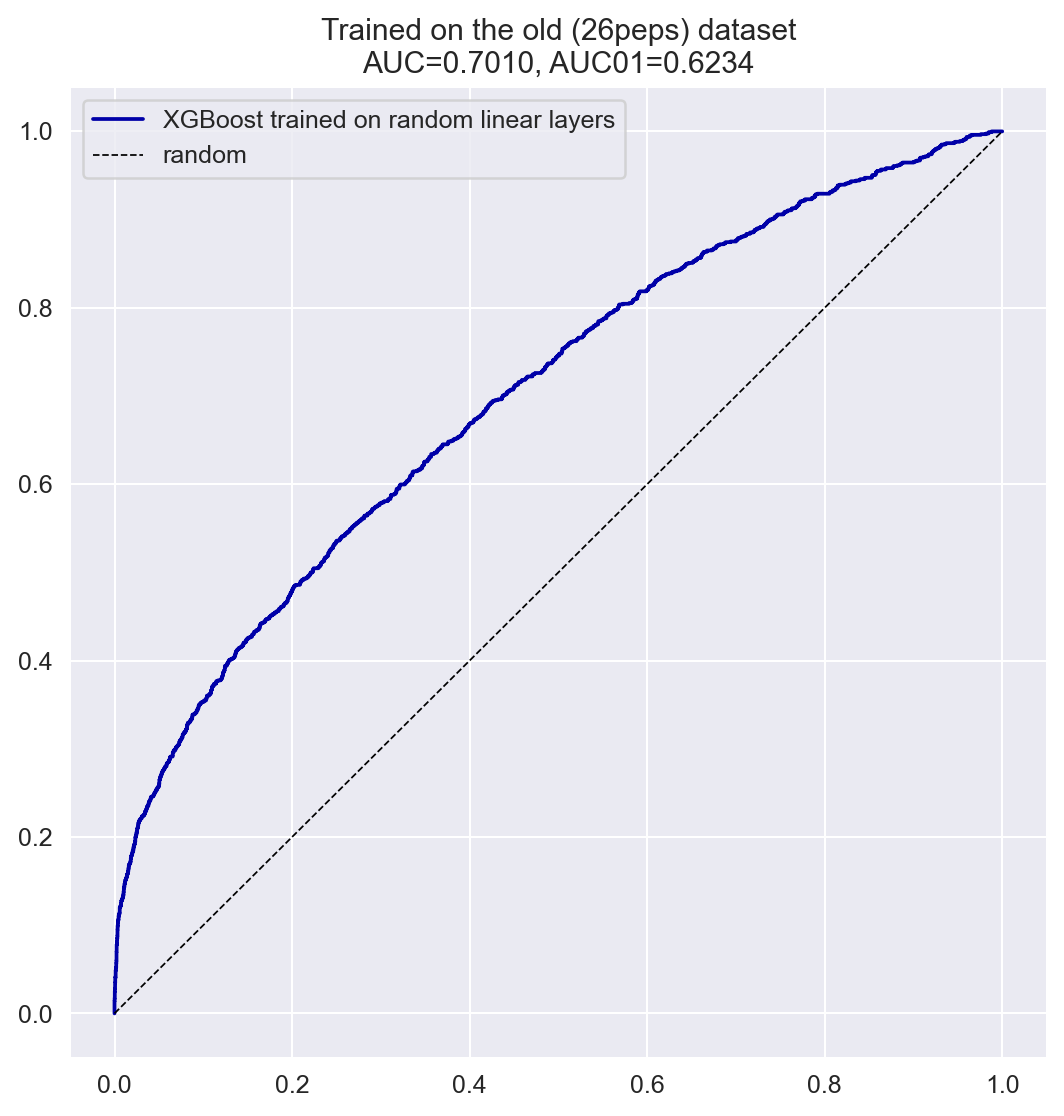

In [298]:
from sklearn.metrics import roc_curve
auc = roc_auc_score(y_valid, valid_pred_reset[:, 1])
auc_01 = roc_auc_score(y_valid, valid_pred_reset[:, 1], max_fpr=0.1)
fpr, tpr, _ = roc_curve(y_valid, valid_pred_reset[:, 1])
f,a = plt.subplots(1,1, figsize=(7,7))
a.plot(fpr, tpr, label='XGBoost trained on random linear layers')
a.plot([0,1], [0,1], label='random', ls='--', lw=0.7, c='k')
a.legend()
a.set_title(f'Trained on the old (26peps) dataset\nAUC={auc:.4f}, AUC01={auc01:.4f}')

## Comparing XGBLSM to NetTCR2.3

In [173]:
# get blosum perf
xgblsm_preds_df = [] 
for outer_partition in sorted(new_df.partition.unique()):
    test_preds = []
    
    test = new_df.query('partition==@outer_partition')
    test_blsm = FullTCRDataset(test, 7, 8, 22, 6, 7, 23, 12)
    test_labels = test_blsm.df['binder'].values
    print('Outer partition: ',outer_partition)
    for inner_partition in filter(lambda x: x!=outer_partition, sorted(new_df.partition.unique())):
        train = new_df.query('partition != @outer_partition and partition != @inner_partition')
        # valid = new_df.query('partition==@inner_partition')
        
        train_blsm = FullTCRDataset(train, 7, 8, 22, 6, 7, 23, 12)
        train_labels = train_blsm.df['binder'].values
        
        # valid_blsm = FullTCRDataset(valid, 7, 8, 22, 6, 7, 23, 12)
        # valid_labels = valid_blsm.df['binder'].values
        
        xgb_blsm = XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.1, min_child_weight=3)
        xgb_blsm.fit(train_blsm.x, train_labels)
        
        # train_pred = xgb_blsm.predict_proba(train_blsm.x)[:, 1]
        # valid_pred = xgb_blsm.predict_proba(valid_blsm.x)[:, 1]
        test_preds.append(xgb_blsm.predict_proba(test_blsm.x)[:, 1])
        print(f'inner:{inner_partition}')
        
        # train_pred = xgb_blsm.predict_proba(train_blsm.x)[:, 1]
        # valid_pred = xgb_blsm.predict_proba(valid_blsm.x)[:, 1]
        
        # train_auc = roc_auc_score(train_labels, train_pred)
        # valid_auc = roc_auc_score(valid_labels, valid_pred)
        # train_auc01 = roc_auc_score(train_labels, train_pred, max_fpr=0.1)
        # valid_auc01 = roc_auc_score(valid_labels, valid_pred, max_fpr=0.1)
        # print(f'Inner partition: ', inner_partition)
        # print(f'\tAUC:\t{round(train_auc, 4):.4f} tr,\t{round(valid_auc, 4):.4f} val')
        # print(f'\tAUC_01:\t{round(train_auc01, 4):.4f} tr,\t{round(valid_auc01, 4):.4f} val')
        
    test_preds = np.stack(test_preds, axis=1).mean(axis=1)
    # test_auc = roc_auc_score(test_labels, test_preds)
    # test_auc01 = roc_auc_score(test_labels, test_preds, max_fpr=0.1)

    test['prediction'] = test_preds
    print(f'\ttest AUC:\t{round(test_auc, 4):.4f},\ttest AUC_01:\t{round(test_auc01, 4):.4f}')
    xgblsm_preds_df.append(test)

Outer partition:  0
inner:1
inner:2


KeyboardInterrupt: 

In [172]:
xgblsm_preds_df.to_csv('../output/240410_XGBoostBLOSUM_nested5cv_preds.csv')
%rm -r ../output/240402_clf_logs_sorting/results_sorting/XGBoostBLOSUM_XGBLSM
%rm -r ../output/240402_clf_logs_sorting/results_sorting/XGBoostBLOSUM
%mkdir ../output/240402_clf_logs_sorting/results_sorting/XGBoostBLOSUM_XGBLSM
xgblsm_preds_df.query('partition==0').rename(columns={'prediction':'pred_prob'}).to_csv('../output/240402_clf_logs_sorting/results_sorting/XGBoostBLOSUM_XGBLSM/240410_XGBoostBLOSUM_nested_part0_preds_XGBLSM.csv')

rm: ../output/240402_clf_logs_sorting/results_sorting/XGBoostBLOSUM: No such file or directory


In [114]:
nettcr = pd.read_csv('../data/NetTCR/NetTCR_2-3_predictions_partition_0_paired_only.csv')
for p in sorted(nettcr.partition.unique()):
    ntcr = nettcr.query('partition==@p')
    a=roc_auc_score(ntcr['binder'], ntcr['prediction'])
    b=roc_auc_score(ntcr['binder'], ntcr['prediction'], max_fpr=0.1)
    print(f'Partition: {p},\tAUC={a:.4f},\tAUC01={b:.4f}')

Partition: 0,	AUC=0.7926,	AUC01=0.6416
Partition: 1,	AUC=0.7797,	AUC01=0.6017
Partition: 2,	AUC=0.8195,	AUC01=0.6615
Partition: 3,	AUC=0.7937,	AUC01=0.6484
Partition: 4,	AUC=0.7805,	AUC01=0.5857


In [124]:
for p in sorted(xgblsm_preds_df.partition.unique()):
    xd = xgblsm_preds_df.query('partition==@p')
    a=roc_auc_score(xd['binder'], xd['prediction'])
    b=roc_auc_score(xd['binder'], xd['prediction'], max_fpr=0.1)
    print(f'Partition: {p},\tAUC={a:.4f},\tAUC01={b:.4f}')

Partition: 0,	AUC=0.8187,	AUC01=0.6997
Partition: 1,	AUC=0.8175,	AUC01=0.6926
Partition: 2,	AUC=0.8354,	AUC01=0.7103
Partition: 3,	AUC=0.8183,	AUC01=0.7031
Partition: 4,	AUC=0.8271,	AUC01=0.6986


In [342]:
xgblsm_preds_df = pd.read_csv('../output/240410_XGBoost/240410_XGBoostBLOSUM_nested5cv_preds.csv')
xgblsm_preds_df

,Unnamed: 0,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,raw_index,reference,source_organism,input_type,len_q,prediction
0,1,KLGGALQAK,TISGTDY,GLTSN,ILTETSYDKVI,SEHNR,FQNEAQ,ASASLGGGLYEQY,HLA-A*03:01,0,0,peptide_swapped,ITRAP_793,37133356,NaN,tcr_pep,7,0.070393
1,9,NYNYLYRLF,TSINN,IRSNERE,ATEDYKLS,SEHNR,FQNEAQ,ASSEGAWAGNTIY,HLA-A*24:02,0,0,peptide_swapped,VDJdb_80557,35750048,SARS-CoV-2,tcr_pep,5,0.139906
2,10,GILGFVFTL,DSAIYN,IQSSQRE,AVLRMDSSYKLI,DFQATT,SNEGSKA,SAGSGTRGETQY,HLA-A*02:01,0,0,peptide_swapped,ITRAP_4341,37133356,NaN,tcr_pep,6,0.031610
3,21,TTDPSFLGRY,NSASQS,VYSSG,VALMNRDDKII,SGDLS,YYNGEE,ASSVGDGSPWKY,HLA-A*01:01,0,0,peptide_swapped,VDJdb_22279,NaN,HCV,tcr_pep,6,0.088304
4,33,AVFDRKSDAK,TSENNYY,QEAYKQQN,AFMKTGVGTSYDKVI,SGHDN,FVKESK,ASSHPEGDVLT,HLA-A*11:01,0,0,peptide_swapped,VDJdb_67603,31811120,InfluenzaA,tcr_pep,7,0.173305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58609,58589,GILGFVFTL,DSSSTY,IFSNMDM,AEDNYGQNFV,SQVTM,ANQGSEA,SGREDSTNEKLF,HLA-A*02:01,4,0,peptide_swapped,VDJdb_65586,28636592,EBV,tcr_pep,6,0.032011
58610,58595,LLWNGPMAV,VSNAYN,GSKP,AVEGNYGGSQGNLI,LNHDA,SQIVND,ASSINPSSYNEQF,HLA-A*02:01,4,0,peptide_swapped,VDJdb_76671,34793243,SARS-CoV-2,tcr_pep,6,0.077548
58611,58596,NYNYLYRLF,NSAFQY,TYSSGN,AMSANKGGYNKLI,KGHDR,SFDVKD,ATSDLVEDTQY,HLA-A*24:02,4,0,peptide_swapped,VDJdb_78954,34793243,SARS-CoV-2,tcr_pep,6,0.117103
58612,58599,AVFDRKSDAK,TRDTTYY,RNSFDEQN,ALSEAGKTSYDKVI,MGHRA,YSYEKL,ASSQVEAFYEQY,HLA-A*11:01,4,0,peptide_swapped,VDJdb_65976,28636592,InfluenzaA,tcr_pep,7,0.275796


In [343]:
xddd = pd.read_csv('../data/NetTCR/nettcr_cv_preds_stripped.txt')
xddd

,B3,A3,binder,partition,peptide,prediction
0,ASASLGGGLYEQY,ILTETSYDKVI,0,0,KLGGALQAK,0.097810
1,ASSEGAWAGNTIY,ATEDYKLS,0,0,NYNYLYRLF,0.036365
2,SAGSGTRGETQY,AVLRMDSSYKLI,0,0,GILGFVFTL,0.025441
3,ASSVGDGSPWKY,VALMNRDDKII,0,0,TTDPSFLGRY,0.053780
4,ASSHPEGDVLT,AFMKTGVGTSYDKVI,0,0,AVFDRKSDAK,0.157018
...,...,...,...,...,...,...
58609,SGREDSTNEKLF,AEDNYGQNFV,0,4,GILGFVFTL,0.011827
58610,ASSINPSSYNEQF,AVEGNYGGSQGNLI,0,4,LLWNGPMAV,0.024280
58611,ATSDLVEDTQY,AMSANKGGYNKLI,0,4,NYNYLYRLF,0.068088
58612,ASSQVEAFYEQY,ALSEAGKTSYDKVI,0,4,AVFDRKSDAK,0.214173


In [344]:
comp_df = []
for p in xgblsm_preds_df.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).index:
    xgb_subset = xgblsm_preds_df.query('peptide==@p')
    ntr_subset = xddd.query('peptide==@p')
    n_pos = len(xgb_subset.query("binder==1"))
    xgb_auc = round(roc_auc_score(xgb_subset['binder'], xgb_subset['prediction']), 4)
    ntr_auc = round(roc_auc_score(ntr_subset['binder'], ntr_subset['prediction']), 4)
    xgb_auc01 = round(roc_auc_score(xgb_subset['binder'], xgb_subset['prediction'], max_fpr=0.1), 4)
    ntr_auc01 = round(roc_auc_score(ntr_subset['binder'], ntr_subset['prediction'], max_fpr=0.1), 4)
    print(f'Peptide: {p}\tNpos={n_pos}\tXGBoost:{xgb_auc}\tNetTCR:{ntr_auc}')
    comp_df.append({'peptide':p, 'n_pos':n_pos, 'XGBlsm_AUC':xgb_auc,'XGBlsm_AUC01':xgb_auc01, 'NetTCR_AUC':ntr_auc,'NetTCR_AUC01':ntr_auc01})

Peptide: GILGFVFTL	Npos=1165	XGBoost:0.8883	NetTCR:0.8781
Peptide: KLGGALQAK	Npos=901	XGBoost:0.7306	NetTCR:0.6943
Peptide: RAKFKQLL	Npos=830	XGBoost:0.9326	NetTCR:0.9135
Peptide: AVFDRKSDAK	Npos=717	XGBoost:0.6806	NetTCR:0.659
Peptide: ELAGIGILTV	Npos=457	XGBoost:0.9597	NetTCR:0.9453
Peptide: SPRWYFYYL	Npos=449	XGBoost:0.8415	NetTCR:0.8173
Peptide: YLQPRTFLL	Npos=399	XGBoost:0.8238	NetTCR:0.8194
Peptide: TTDPSFLGRY	Npos=387	XGBoost:0.7958	NetTCR:0.7915
Peptide: LLWNGPMAV	Npos=371	XGBoost:0.9039	NetTCR:0.8783
Peptide: NLVPMVATV	Npos=368	XGBoost:0.7538	NetTCR:0.7218
Peptide: IVTDFSVIK	Npos=316	XGBoost:0.7239	NetTCR:0.7509
Peptide: GLCTLVAML	Npos=271	XGBoost:0.9045	NetTCR:0.8626
Peptide: CINGVCWTV	Npos=226	XGBoost:0.898	NetTCR:0.8705
Peptide: QYIKWPWYI	Npos=132	XGBoost:0.7406	NetTCR:0.7306
Peptide: LTDEMIAQY	Npos=129	XGBoost:0.7433	NetTCR:0.7108
Peptide: KTFPPTEPK	Npos=119	XGBoost:0.671	NetTCR:0.6616
Peptide: ATDALMTGF	Npos=103	XGBoost:0.8583	NetTCR:0.8082
Peptide: DATYQRTRALVR	Npos=92	X

In [345]:
comp_df=pd.DataFrame(comp_df)
comp_df.to_csv('./XGBLSM_NetTCR_per_pep_nested_comparison.csv')

In [ ]:
comp_df.peptide.values

In [142]:
comp_df['XGBLSM_wins'] = comp_df['XGBlsm_AUC'] > comp_df['NetTCR_AUC']
comp_df.groupby('XGBLSM_wins').count()

,peptide,n_pos,XGBlsm_AUC,XGBlsm_AUC01,NetTCR_AUC,NetTCR_AUC01
XGBLSM_wins,,,,,,
False,55,55,55,55,55,55
True,115,115,115,115,115,115


In [151]:
comp_df['delta_AUC'] = comp_df['XGBlsm_AUC'] = comp_df['NetTCR_AUC']

In [146]:
xd = comp_df.query('n_pos>100')
xd['XGBLSM_wins'] = xd['XGBlsm_AUC'] > xd['NetTCR_AUC']
xd.groupby('XGBLSM_wins').count()

,peptide,n_pos,XGBlsm_AUC,XGBlsm_AUC01,NetTCR_AUC,NetTCR_AUC01
XGBLSM_wins,,,,,,
False,1,1,1,1,1,1
True,16,16,16,16,16,16


## Comparing to Mathias' old NetTCR2.2 pan predictions

In [176]:
# get XGBLSM performance for the old dataset (26 peptides)
xgblsm_old_preds_df = [] 
for outer_partition in sorted(new_df.partition.unique()):
    test_preds = []
    
    test = old_df.query('partition==@outer_partition')
    test_blsm = FullTCRDataset(test, 7, 8, 22, 6, 7, 23, 12)
    test_labels = test_blsm.df['binder'].values
    print('Outer partition: ',outer_partition)
    for inner_partition in filter(lambda x: x!=outer_partition, sorted(new_df.partition.unique())):
        train = old_df.query('partition != @outer_partition and partition != @inner_partition')
        valid = old_df.query('partition==@inner_partition')
        
        train_blsm = FullTCRDataset(train, 7, 8, 22, 6, 7, 23, 12)
        train_labels = train_blsm.df['binder'].values
        
        valid_blsm = FullTCRDataset(valid, 7, 8, 22, 6, 7, 23, 12)
        valid_labels = valid_blsm.df['binder'].values
        
        xgb_blsm = XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.1, min_child_weight=3)
        xgb_blsm.fit(train_blsm.x, train_labels)
        
        train_pred = xgb_blsm.predict_proba(train_blsm.x)[:, 1]
        valid_pred = xgb_blsm.predict_proba(valid_blsm.x)[:, 1]
        test_preds.append(xgb_blsm.predict_proba(test_blsm.x)[:, 1])
        print(f'inner:{inner_partition}')
        
        train_pred = xgb_blsm.predict_proba(train_blsm.x)[:, 1]
        valid_pred = xgb_blsm.predict_proba(valid_blsm.x)[:, 1]
        
        train_auc = roc_auc_score(train_labels, train_pred)
        valid_auc = roc_auc_score(valid_labels, valid_pred)
        train_auc01 = roc_auc_score(train_labels, train_pred, max_fpr=0.1)
        valid_auc01 = roc_auc_score(valid_labels, valid_pred, max_fpr=0.1)
        print(f'Inner partition: ', inner_partition)
        print(f'\tAUC:\t{round(train_auc, 4):.4f} tr,\t{round(valid_auc, 4):.4f} val')
        print(f'\tAUC_01:\t{round(train_auc01, 4):.4f} tr,\t{round(valid_auc01, 4):.4f} val')
        
    test_preds = np.stack(test_preds, axis=1).mean(axis=1)
    test_auc = roc_auc_score(test_labels, test_preds)
    test_auc01 = roc_auc_score(test_labels, test_preds, max_fpr=0.1)

    test['prediction'] = test_preds
    print(f'\ttest AUC:\t{round(test_auc, 4):.4f},\ttest AUC_01:\t{round(test_auc01, 4):.4f}')
    xgblsm_old_preds_df.append(test)

Outer partition:  0
inner:1
Inner partition:  1
	AUC:	1.0000 tr,	0.8560 val
	AUC_01:	0.9998 tr,	0.7339 val
inner:2
Inner partition:  2
	AUC:	1.0000 tr,	0.8565 val
	AUC_01:	0.9997 tr,	0.7307 val
inner:3
Inner partition:  3
	AUC:	1.0000 tr,	0.8500 val
	AUC_01:	0.9999 tr,	0.7180 val
inner:4
Inner partition:  4
	AUC:	1.0000 tr,	0.8537 val
	AUC_01:	1.0000 tr,	0.7278 val
	test AUC:	0.8607,	test AUC_01:	0.7349
Outer partition:  1
inner:0
Inner partition:  0
	AUC:	1.0000 tr,	0.8492 val
	AUC_01:	0.9998 tr,	0.7273 val
inner:2
Inner partition:  2
	AUC:	0.9999 tr,	0.8551 val
	AUC_01:	0.9996 tr,	0.7277 val
inner:3
Inner partition:  3
	AUC:	1.0000 tr,	0.8517 val
	AUC_01:	0.9999 tr,	0.7242 val
inner:4
Inner partition:  4
	AUC:	1.0000 tr,	0.8550 val
	AUC_01:	0.9998 tr,	0.7249 val
	test AUC:	0.8678,	test AUC_01:	0.7449
Outer partition:  2
inner:0
Inner partition:  0
	AUC:	1.0000 tr,	0.8466 val
	AUC_01:	0.9997 tr,	0.7212 val
inner:1
Inner partition:  1
	AUC:	0.9999 tr,	0.8558 val
	AUC_01:	0.9996 tr,	0.7

In [179]:
xgblsm_old = pd.concat(xgblsm_old_preds_df)

In [177]:
nettcr_pan_old_nosim = pd.read_csv('../data/NetTCR/nettcr22_test_pan_no_sim_preds.csv')
nettcr_pan_old_rescale = pd.read_csv('../data/NetTCR/nettcr22_test_pan_rescaled_w_sim_preds.csv')

In [190]:
print('model\t\t\tAUC\tAUC01')
print(f"XGBLSM \t\t\t{roc_auc_score(xgblsm_old['binder'], xgblsm_old['prediction']):.4f}, {roc_auc_score(xgblsm_old['binder'], xgblsm_old['prediction'], max_fpr=0.1):.4f}")
print(f"N2.2 nosim\t\t{roc_auc_score(nettcr_pan_old_nosim['binder'], nettcr_pan_old_nosim['prediction']):.4f}, {roc_auc_score(nettcr_pan_old_nosim['binder'], nettcr_pan_old_nosim['prediction'], max_fpr=0.1):.4f}")
print(f"N2.2 simRescaled\t{roc_auc_score(nettcr_pan_old_rescale['binder'], nettcr_pan_old_rescale['prediction']):.4f}, {roc_auc_score(nettcr_pan_old_rescale['binder'], nettcr_pan_old_rescale['prediction'], max_fpr=0.1):.4f}")

model			AUC	AUC01
XGBLSM 			0.8668, 0.7402
N2.2 nosim		0.8650, 0.7313
N2.2 simRescaled	0.8700, 0.7448


In [194]:
comp_df_old = []
for p in xgblsm_old.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).index:
    xgb_subset = xgblsm_old.query('peptide==@p')
    ntr_subset = nettcr_pan_old_nosim.query('peptide==@p')
    n_pos = len(xgb_subset.query("binder==1"))
    xgb_auc = round(roc_auc_score(xgb_subset['binder'], xgb_subset['prediction']), 4)
    ntr_auc = round(roc_auc_score(ntr_subset['binder'], ntr_subset['prediction']), 4)
    xgb_auc01 = round(roc_auc_score(xgb_subset['binder'], xgb_subset['prediction'], max_fpr=0.1), 4)
    ntr_auc01 = round(roc_auc_score(ntr_subset['binder'], ntr_subset['prediction'], max_fpr=0.1), 4)

    ntr_subset = nettcr_pan_old_rescale.query('peptide==@p')
    ntr_auc_rescaled = round(roc_auc_score(ntr_subset['binder'], ntr_subset['prediction']), 4)
    ntr_auc01_rescaled = round(roc_auc_score(ntr_subset['binder'], ntr_subset['prediction'], max_fpr=0.1), 4)
    
    print(f'Peptide: {p}\tNpos={n_pos}\tXGBoost:{xgb_auc}\tNetTCR:{ntr_auc}')
    comp_df_old.append({'peptide':p, 'n_pos':n_pos, 'XGBlsm_AUC':xgb_auc,'XGBlsm_AUC01':xgb_auc01, 
                    'NetTCR_noSim_AUC':ntr_auc,'NetTCR_noSim_AUC01':ntr_auc01, 
                    'NetTCR_rescale_AUC':ntr_auc_rescaled, 'NetTCR_rescale_AUC01':ntr_auc01_rescaled})

Peptide: GILGFVFTL	Npos=1125	XGBoost:0.8999	NetTCR:0.8961
Peptide: RAKFKQLL	Npos=934	XGBoost:0.9225	NetTCR:0.913
Peptide: KLGGALQAK	Npos=902	XGBoost:0.7777	NetTCR:0.7901
Peptide: AVFDRKSDAK	Npos=716	XGBoost:0.7369	NetTCR:0.7473
Peptide: ELAGIGILTV	Npos=426	XGBoost:0.9602	NetTCR:0.9599
Peptide: NLVPMVATV	Npos=330	XGBoost:0.7765	NetTCR:0.7851
Peptide: IVTDFSVIK	Npos=308	XGBoost:0.7799	NetTCR:0.7908
Peptide: LLWNGPMAV	Npos=229	XGBoost:0.8793	NetTCR:0.8808
Peptide: CINGVCWTV	Npos=226	XGBoost:0.9246	NetTCR:0.9136
Peptide: GLCTLVAML	Npos=212	XGBoost:0.9038	NetTCR:0.8867
Peptide: SPRWYFYYL	Npos=149	XGBoost:0.8492	NetTCR:0.8552
Peptide: ATDALMTGF	Npos=103	XGBoost:0.8967	NetTCR:0.8544
Peptide: DATYQRTRALVR	Npos=93	XGBoost:0.8377	NetTCR:0.856
Peptide: KSKRTPMGF	Npos=89	XGBoost:0.8919	NetTCR:0.8645
Peptide: YLQPRTFLL	Npos=62	XGBoost:0.9036	NetTCR:0.9353
Peptide: HPVTKYIM	Npos=53	XGBoost:0.87	NetTCR:0.8848
Peptide: RFPLTFGWCF	Npos=51	XGBoost:0.8116	NetTCR:0.8101
Peptide: GPRLGVRAT	Npos=48	XGBoost:

In [198]:
comp_df_old = pd.DataFrame(comp_df_old)

In [199]:
comp_df_old['XGBLSM_wins_noSim'] = comp_df_old['XGBlsm_AUC'] > comp_df_old['NetTCR_noSim_AUC']
comp_df_old['XGBLSM_wins_rescale'] = comp_df_old['XGBlsm_AUC'] > comp_df_old['NetTCR_rescale_AUC']
display(comp_df_old.groupby('XGBLSM_wins_noSim').count())
display(comp_df_old.groupby('XGBLSM_wins_rescale').count())

,peptide,n_pos,XGBlsm_AUC,XGBlsm_AUC01,NetTCR_noSim_AUC,NetTCR_noSim_AUC01,NetTCR_rescale_AUC,NetTCR_rescale_AUC01,XGBLSM_wins_rescale
XGBLSM_wins_noSim,,,,,,,,,
False,14,14,14,14,14,14,14,14,14
True,12,12,12,12,12,12,12,12,12


,peptide,n_pos,XGBlsm_AUC,XGBlsm_AUC01,NetTCR_noSim_AUC,NetTCR_noSim_AUC01,NetTCR_rescale_AUC,NetTCR_rescale_AUC01,XGBLSM_wins_noSim
XGBLSM_wins_rescale,,,,,,,,,
False,18,18,18,18,18,18,18,18,18
True,8,8,8,8,8,8,8,8,8


In [201]:


display(comp_df_old.head(15).groupby('XGBLSM_wins_noSim').count())
display(comp_df_old.head(15).groupby('XGBLSM_wins_rescale').count())

,peptide,n_pos,XGBlsm_AUC,XGBlsm_AUC01,NetTCR_noSim_AUC,NetTCR_noSim_AUC01,NetTCR_rescale_AUC,NetTCR_rescale_AUC01,XGBLSM_wins_rescale
XGBLSM_wins_noSim,,,,,,,,,
False,8,8,8,8,8,8,8,8,8
True,7,7,7,7,7,7,7,7,7


,peptide,n_pos,XGBlsm_AUC,XGBlsm_AUC01,NetTCR_noSim_AUC,NetTCR_noSim_AUC01,NetTCR_rescale_AUC,NetTCR_rescale_AUC01,XGBLSM_wins_noSim
XGBLSM_wins_rescale,,,,,,,,,
False,9,9,9,9,9,9,9,9,9
True,6,6,6,6,6,6,6,6,6


In [203]:
comp_df_old['delta_AUC_noSim'] = comp_df_old['XGBlsm_AUC'] - comp_df_old['NetTCR_noSim_AUC']
comp_df_old['delta_AUC_rescale'] = comp_df_old['XGBlsm_AUC'] - comp_df_old['NetTCR_rescale_AUC']

In [204]:
comp_df_old.to_csv

,peptide,n_pos,XGBlsm_AUC,XGBlsm_AUC01,NetTCR_noSim_AUC,NetTCR_noSim_AUC01,NetTCR_rescale_AUC,NetTCR_rescale_AUC01,XGBLSM_wins_noSim,XGBLSM_wins_rescale,delta_AUC_noSim,delta_AUC_rescale
0,GILGFVFTL,1125,0.8999,0.8398,0.8961,0.8362,0.8964,0.8361,True,True,0.0038,0.0035
1,RAKFKQLL,934,0.9225,0.8568,0.9130,0.8557,0.9159,0.8595,True,True,0.0095,0.0066
2,KLGGALQAK,902,0.7777,0.5891,0.7901,0.5841,0.7952,0.6012,False,False,-0.0124,-0.0175
3,AVFDRKSDAK,716,0.7369,0.5567,0.7473,0.5592,0.7527,0.5727,False,False,-0.0104,-0.0158
4,ELAGIGILTV,426,0.9602,0.8846,0.9599,0.8807,0.9606,0.8838,True,False,0.0003,-0.0004
5,NLVPMVATV,330,0.7765,0.6202,0.7851,0.6272,0.7896,0.6396,False,False,-0.0086,-0.0131
6,IVTDFSVIK,308,0.7799,0.6699,0.7908,0.6717,0.7957,0.6857,False,False,-0.0109,-0.0158
7,LLWNGPMAV,229,0.8793,0.8177,0.8808,0.8028,0.8832,0.8105,False,False,-0.0015,-0.0039
8,CINGVCWTV,226,0.9246,0.8368,0.9136,0.8087,0.9172,0.8241,True,True,0.0110,0.0074
9,GLCTLVAML,212,0.9038,0.8085,0.8867,0.7716,0.8995,0.8058,True,True,0.0171,0.0043


In [206]:
comp_df_old.to_csv('../output/240410_XGBoost/XGBLSM_OLD26pep_NetTCR_per_pep_nested_comparison.csv')
xgblsm_old.to_csv('../output/240410_XGBoost/240410_OLD26pep_XGBoostBLOSUM_nested5cv_preds.csv')
# %rm -r ../output/240402_clf_logs_sorting/results_sorting/XGBoostBLOSUM
# %mkdir ../output/240402_clf_logs_sorting/results_sorting/XGBoostBLOSUM_XGBLSM
# xgblsm_preds_df.query('partition==0').rename(columns={'prediction':'pred_prob'}).to_csv('../output/240402_clf_logs_sorting/results_sorting/XGBoostBLOSUM_XGBLSM/240410_XGBoostBLOSUM_nested_part0_preds_XGBLSM.csv')

## check some curves

In [6]:
xgblsm_old = pd.read_csv('../output/240410_XGBoost/240410_OLD26pep_XGBoostBLOSUM_nested5cv_preds.csv')
xgblsm_new = pd.read_csv('../output/240410_XGBoost/240410_XGBoostBLOSUM_nested5cv_preds.csv')
display(xgblsm_new.head())
display(xgblsm_old.head())

,Unnamed: 0,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,raw_index,reference,source_organism,input_type,len_q,prediction
0,1,KLGGALQAK,TISGTDY,GLTSN,ILTETSYDKVI,SEHNR,FQNEAQ,ASASLGGGLYEQY,HLA-A*03:01,0,0,peptide_swapped,ITRAP_793,37133356,NaN,tcr_pep,7,0.070393
1,9,NYNYLYRLF,TSINN,IRSNERE,ATEDYKLS,SEHNR,FQNEAQ,ASSEGAWAGNTIY,HLA-A*24:02,0,0,peptide_swapped,VDJdb_80557,35750048,SARS-CoV-2,tcr_pep,5,0.139906
2,10,GILGFVFTL,DSAIYN,IQSSQRE,AVLRMDSSYKLI,DFQATT,SNEGSKA,SAGSGTRGETQY,HLA-A*02:01,0,0,peptide_swapped,ITRAP_4341,37133356,NaN,tcr_pep,6,0.031610
3,21,TTDPSFLGRY,NSASQS,VYSSG,VALMNRDDKII,SGDLS,YYNGEE,ASSVGDGSPWKY,HLA-A*01:01,0,0,peptide_swapped,VDJdb_22279,NaN,HCV,tcr_pep,6,0.088304
4,33,AVFDRKSDAK,TSENNYY,QEAYKQQN,AFMKTGVGTSYDKVI,SGHDN,FVKESK,ASSHPEGDVLT,HLA-A*11:01,0,0,peptide_swapped,VDJdb_67603,31811120,InfluenzaA,tcr_pep,7,0.173305


,Unnamed: 0.1,Unnamed: 0,A1,A2,A3,B1,B2,B3,peptide,allele,origin,binder,partition,original_peptide,original_index,len_q,prediction
0,3,3,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,KLGGALQAK,HLA-A*03:01,peptide_swapped,0,0,ELAGIGILTV,5933,6,0.046833
1,26,26,TSINN,IRSNERE,ATDAARQLT,SGHAT,FQNNGV,ASSLDLPGPEGETQY,ATDALMTGF,HLA-A*01:01,peptide_swapped,0,0,DATYQRTRALVR,4873,5,0.036830
2,28,28,TISGNEY,GLKNN,IVREWDNYGQNFV,LGHNA,YSLEER,ASSQVAKMAKDNYGYT,ELAGIGILTV,HLA-A*02:01,peptide_swapped,0,0,LLWNGPMAV,4271,7,0.012366
3,33,33,TISGTDY,GLTSN,TDSGAGSYQLT,SGHDT,YYEEEE,ASSLRDGSEAF,KLGGALQAK,HLA-A*03:01,peptide_swapped,0,0,RAKFKQLL,417,7,0.012658
4,34,34,TSDQSYG,QGSYDEQN,AMREGMEYGNKLV,LNHDA,SHIVND,ASSIFSTPNQPQH,GILGFVFTL,HLA-A*02:01,VDJdb,1,0,GILGFVFTL,5429,7,0.737298


In [217]:
from src.metrics import get_metrics
old_comp = {k:get_metrics(v['binder'], v['prediction'], no_curves=False, reduced=False, round_digit=6) for k,v in zip(['XGBLSM', 'NetTCRpan-2.2-noSim', 'NetTCRpan-2.2-SimRescale'],
                                                                                                                      [xgblsm_old, nettcr_pan_old_nosim, nettcr_pan_old_rescale])}

Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing


In [218]:

new_comp = {k:get_metrics(v['binder'], v['prediction'], no_curves=False, reduced=False, round_digit=6) for k,v in zip(['XGBLSM', 'NetTCRpan-2.3'],
                                                                                                                      [xgblsm_new, nettcr])}

Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing


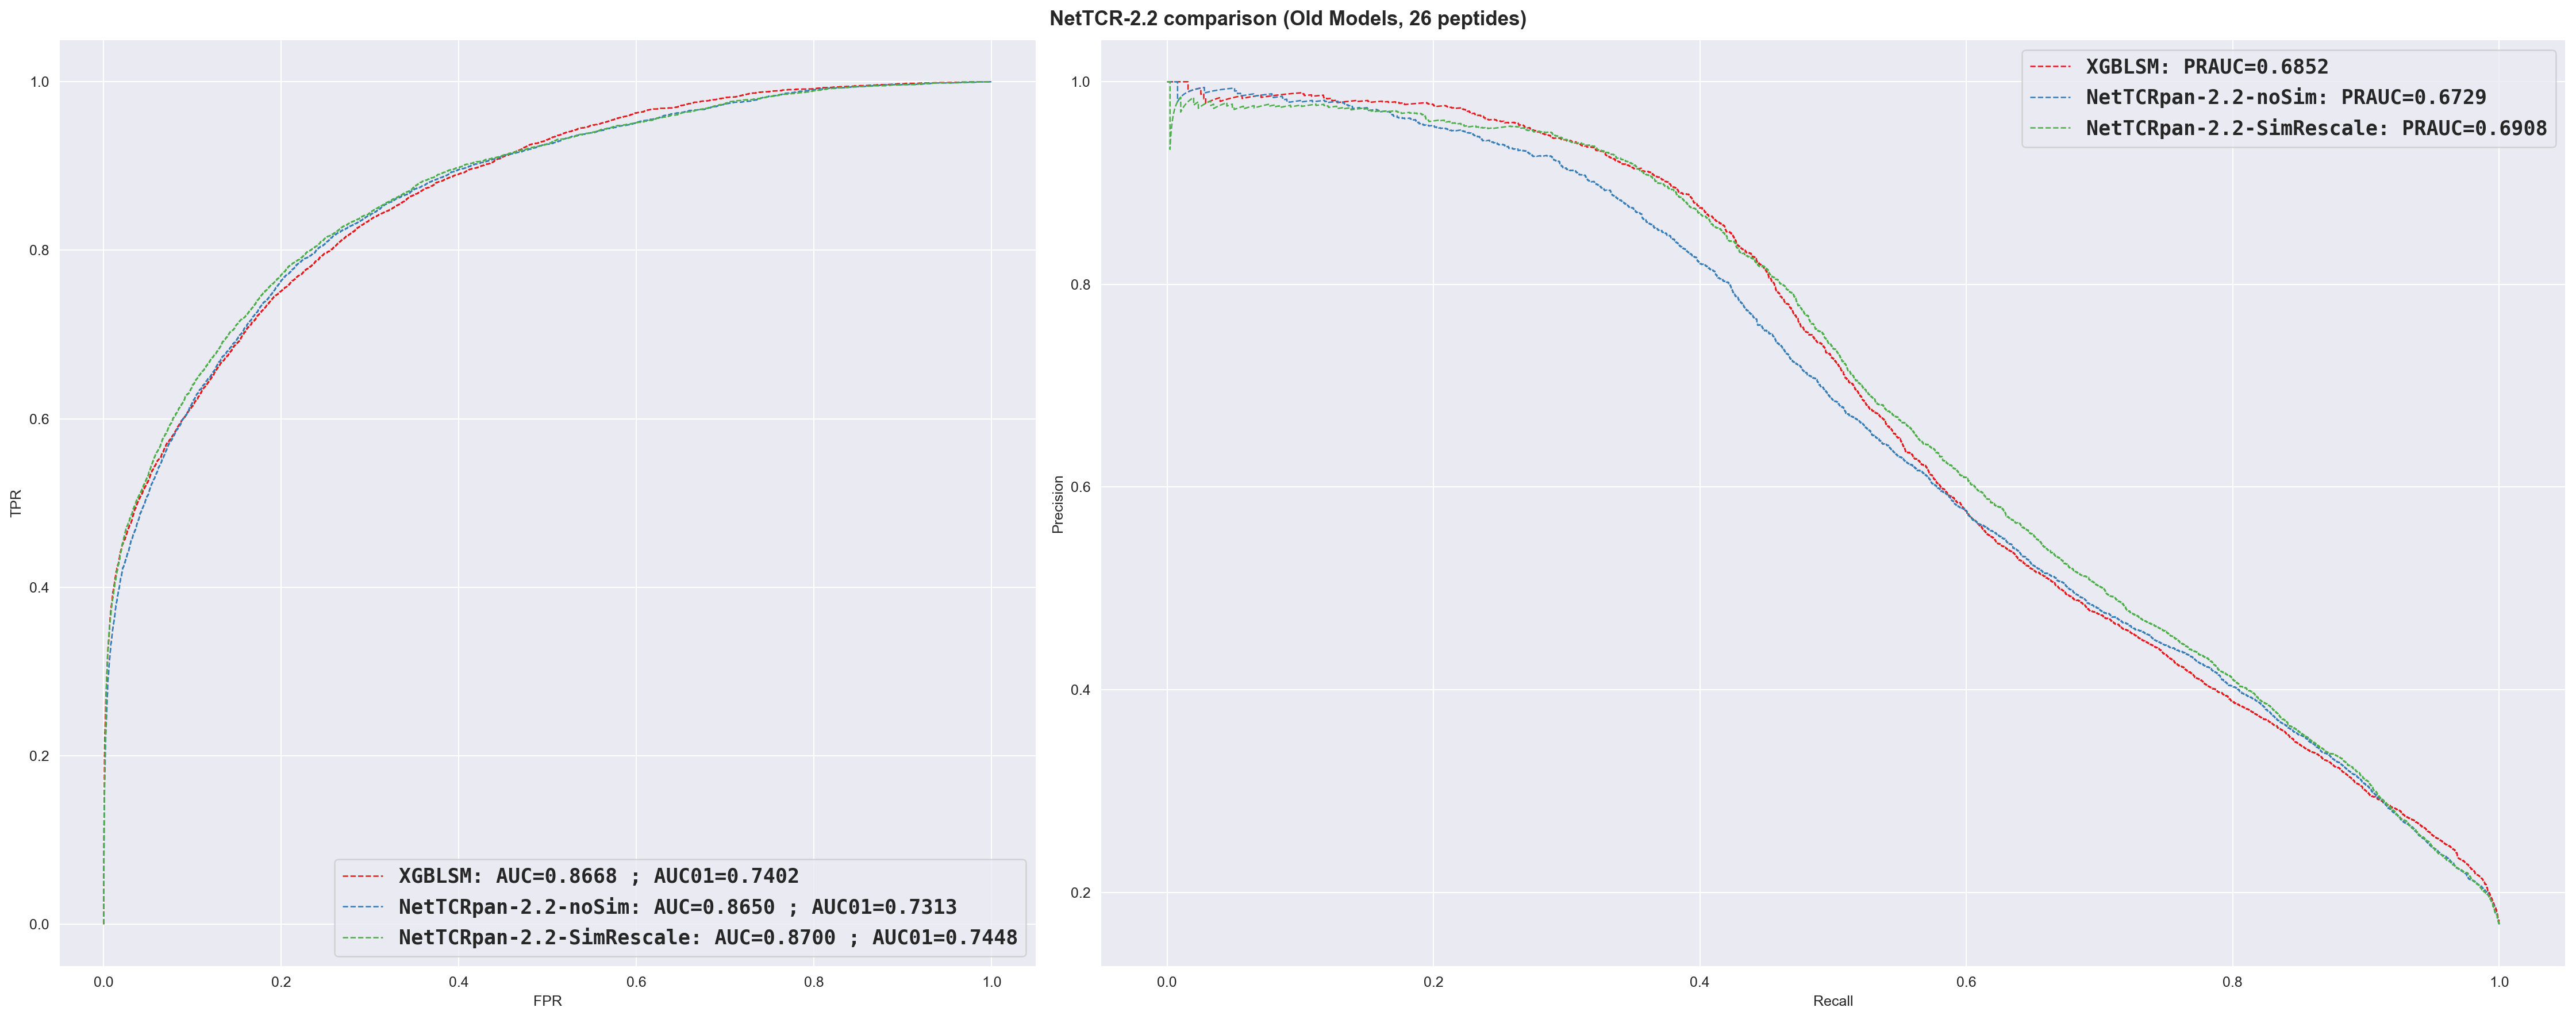

In [231]:
sns.set_palette('Set1', 3)
# f,a = plt.subplots(1,1, figsize=(20,10))
# Define the width ratios for the subplots
width_ratios = [2, 3]

# Create subplots with 1 row and 2 columns, using width_ratios for sizing
fig, ax = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': width_ratios})
ax = ax.ravel()
for k,v in old_comp.items():
    roc = v['roc_curve']
    pr = v['pr_curve']
    auc=v['auc']
    auc01=v['auc_01']
    prauc=v['prauc']
    ax[0].plot(roc[0], roc[1], label=f'{k.replace("PEPBLSM","").split("_")[-1]}: AUC={auc:.4f} ; AUC01={auc01:.4f}', ls='--', lw=1)
    ax[1].plot(pr[0], pr[1], label=f'{k.replace("PEPBLSM","").split("_")[-1]}: PRAUC={prauc:.4f}', ls='--', lw=1)
l1 = ax[0].legend(prop={'weight':'semibold','size':14, 'family':'monospace'})
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')

l2 = ax[1].legend(prop={'weight':'semibold','size':14, 'family':'monospace'})
fig.suptitle('NetTCR-2.2 comparison (Old Models, 26 peptides)', fontweight='semibold', fontsize=14)
fig.tight_layout()

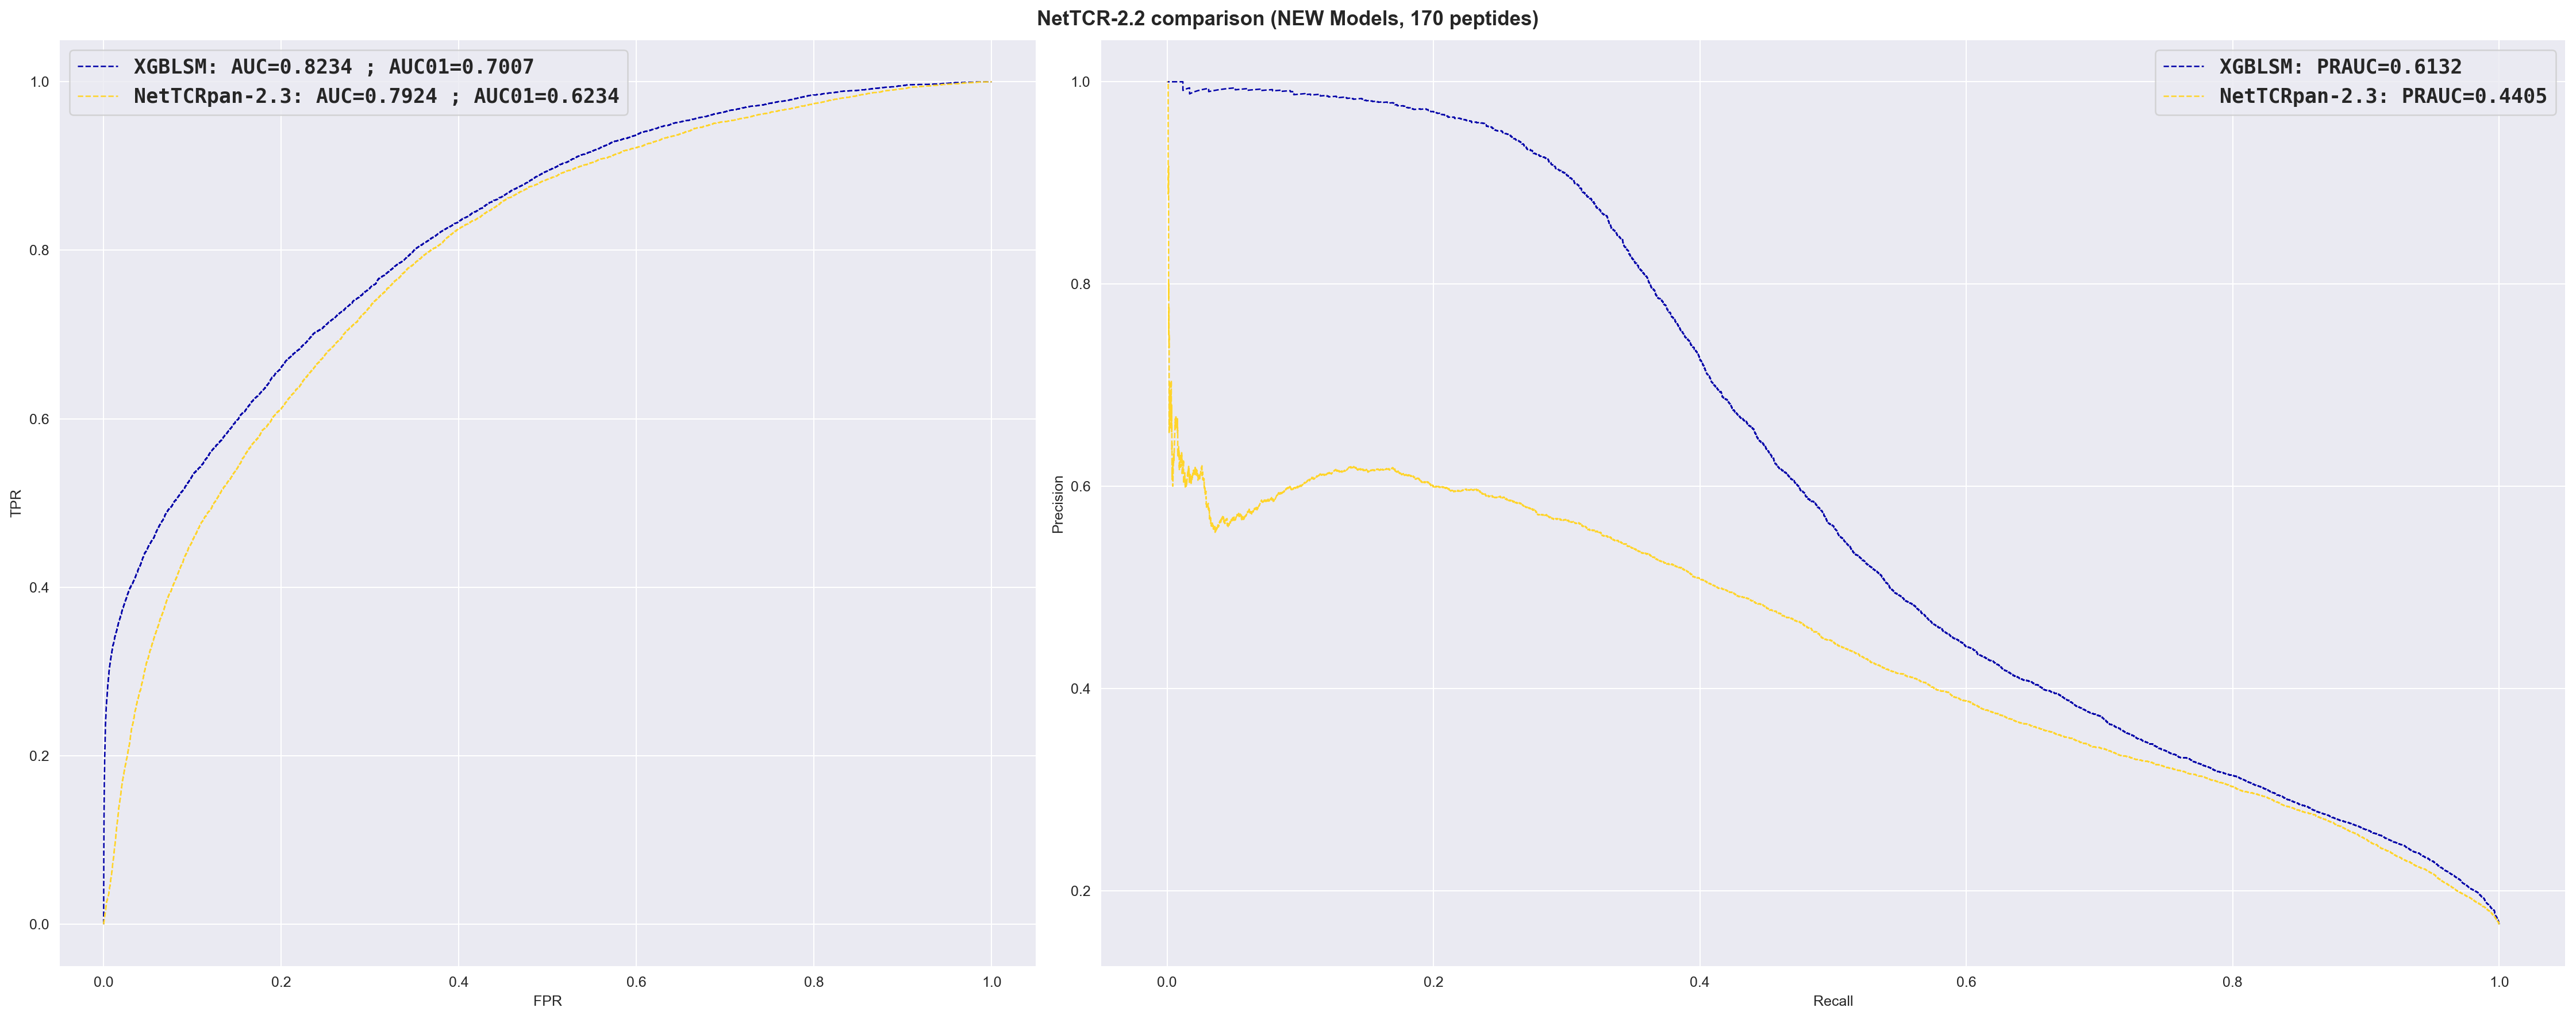

In [232]:
sns.set_palette(get_palette('gnuplot2', 2))
# f,a = plt.subplots(1,1, figsize=(20,10))
# Define the width ratios for the subplots
width_ratios = [2, 3]

# Create subplots with 1 row and 2 columns, using width_ratios for sizing
fig, ax = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': width_ratios})
ax = ax.ravel()
for k,v in new_comp.items():
    roc = v['roc_curve']
    pr = v['pr_curve']
    auc=v['auc']
    auc01=v['auc_01']
    prauc=v['prauc']
    ax[0].plot(roc[0], roc[1], label=f'{k.replace("PEPBLSM","").split("_")[-1]}: AUC={auc:.4f} ; AUC01={auc01:.4f}', ls='--', lw=1)
    ax[1].plot(pr[0], pr[1], label=f'{k.replace("PEPBLSM","").split("_")[-1]}: PRAUC={prauc:.4f}', ls='--', lw=1)
l1 = ax[0].legend(prop={'weight':'semibold','size':14, 'family':'monospace'})
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')

l2 = ax[1].legend(prop={'weight':'semibold','size':14, 'family':'monospace'})
fig.suptitle('NetTCR-2.2 comparison (NEW Models, 170 peptides)', fontweight='semibold', fontsize=14)
fig.tight_layout()

In [323]:
xgblsm_old.query('binder==1').groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).to_csv('bruh.txt', sep= ',')

In [320]:
old_df.query('binder==1').groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).to_csv('bruh.txt', sep= ',')

,count
peptide,
GILGFVFTL,1165
KLGGALQAK,901
RAKFKQLL,830
AVFDRKSDAK,717
ELAGIGILTV,457
...,...
LMNVLTLVY,5
LMIERFVSL,5
LLLDRLNQL,5


In [327]:
%mkdir -p '../data/TCRBASE/tcrbase_expanded_ALL_swapped/'
%mkdir -p '../data/TCRBASE/tcrbase_old_ALL_swapped/'

In [331]:
# Save data for TCRBase
cols = ['A1','A2','A3','B1','B2','B3']
for pep in xgblsm_new.peptide.unique():
    subset = xgblsm_new.query('peptide==@pep')
    for i in xgblsm_new.partition.unique():
        query = subset.query('partition==@i').assign(ID='query')
        db = subset.query('partition!=@i and binder==1').assign(ID='db')
        query[['ID']+cols].to_csv(f'../data/TCRBASE/tcrbase_expanded_ALL_swapped/{pep}_query_p{i}.tsv', sep='\t', index=False, header=False)
        db[['ID']+cols].to_csv(f'../data/TCRBASE/tcrbase_expanded_ALL_swapped/{pep}_db_p{i}.tsv', sep='\t', index=False, header=False)
for pep in xgblsm_old.peptide.unique():
    subset = xgblsm_old.query('peptide==@pep')
    for i in xgblsm_old.partition.unique():
        query = subset.query('partition==@i').assign(ID='query')
        db = subset.query('partition!=@i and binder==1').assign(ID='db')
        query[['ID']+cols].to_csv(f'../data/TCRBASE/tcrbase_old_ALL_swapped/{pep}_query_p{i}.tsv', sep='\t', index=False, header=False)
        db[['ID']+cols].to_csv(f'../data/TCRBASE/tcrbase_old_ALL_swapped/{pep}_db_p{i}.tsv', sep='\t', index=False, header=False)

In [348]:
comp_df.iloc[:,2:].to_csv('expanded.txt', index=False)

In [346]:
comp_df

,peptide,n_pos,XGBlsm_AUC,XGBlsm_AUC01,NetTCR_AUC,NetTCR_AUC01
0,GILGFVFTL,1165,0.8883,0.8400,0.8781,0.8305
1,KLGGALQAK,901,0.7306,0.5702,0.6943,0.5320
2,RAKFKQLL,830,0.9326,0.8632,0.9135,0.8493
3,AVFDRKSDAK,717,0.6806,0.5288,0.6590,0.5212
4,ELAGIGILTV,457,0.9597,0.8973,0.9453,0.8773
...,...,...,...,...,...,...
165,LMNVLTLVY,5,0.6240,0.4737,0.7440,0.4737
166,LMIERFVSL,5,0.7520,0.6842,0.6480,0.4947
167,LLLDRLNQL,5,0.6240,0.6842,0.5200,0.4737
168,LLFLVLIML,5,0.6400,0.4737,0.6720,0.5579


In [1]:
comp_df_old.iloc[:,2:8].to_csv('old.txt', index=False)

NameError: name 'comp_df_old' is not defined

# 240425 Make a curve plot comparing XGBoost, NetTCR, VAEMLPs for section meeting

In [8]:
%ls ../output/240402_clf_logs_sorting/240425_NewFigureSectionMeeting/

CDR3ONLY_1STAGE_NOTRP/ FULLTCR_1STAGE_NOTRP/  Reset_Model_(Epoch_0)/
FULLTCR_1STAGE_COSTRP/ FULLTCR_2STAGE_NOTRP/


In [18]:
from src.metrics import get_metrics
nettcr = pd.read_csv('../data/NetTCR/NetTCR_2-3_predictions_partition_0_paired_only.csv')
xgblsm_new = pd.read_csv('../output/240410_XGBoost/240410_XGBoostBLOSUM_nested5cv_preds.csv').query('partition==0')

new_comp = {k:get_metrics(v['binder'], v['prediction'], no_curves=False, reduced=False, round_digit=6) for k,v in zip(['XGBLSM', 'NetTCRpan-2.2'],
                                                                                                                      [xgblsm_new, nettcr])}

Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing


In [19]:
dd= {'CDR3ONLY_1STAGE_NOTRP':'CDR3 1-Stage ; No Triplet', 
     'FULLTCR_1STAGE_COSTRP': 'AllCDRs 1-Stage ; Cos Triplet', 
     'FULLTCR_1STAGE_NOTRP': 'AllCDRs 1-Stage ; No Triplet', 
     'FULLTCR_2STAGE_NOTRP': 'AllCDRs 2-Stage ; No Triplet',
     'Reset_Model_(Epoch_0)':'Reset VAE'}

In [20]:
fs = sorted(glob.glob('../output/240402_clf_logs_sorting/240425_NewFigureSectionMeeting/*/*pred*.csv'))
for k in fs:
    key = dd[k.split('/')[-2]]
    new_comp[key]  = get_metrics(pd.read_csv(k).query('partition==0')['binder'], pd.read_csv(k).query('partition==0')['pred_prob'], no_curves=False, reduced=False,round_digit=6)

Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing


In [28]:
 sns.color_palette('tab10',8)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)]

In [26]:
#palette = 
pal = sns.color_palette('tab10',8)

In [29]:
dd

{'CDR3ONLY_1STAGE_NOTRP': 'CDR3 1-Stage ; No Triplet',
 'FULLTCR_1STAGE_COSTRP': 'AllCDRs 1-Stage ; Cos Triplet',
 'FULLTCR_1STAGE_NOTRP': 'AllCDRs 1-Stage ; No Triplet',
 'FULLTCR_2STAGE_NOTRP': 'AllCDRs 2-Stage ; No Triplet',
 'Reset_Model_(Epoch_0)': 'Reset VAE'}

[(0.0, 0.0, 0.3607843137254902),
 (0.0, 0.0, 0.7215686274509804),
 (0.06433823529411753, 0.0, 1.0),
 (0.3584558823529411, 0.0, 1.0),
 (0.6403186274509804, 0.06980392156862747, 0.9301960784313726),
 (0.9221813725490193, 0.2501960784313725, 0.7498039215686276),
 (1.0, 0.4305882352941176, 0.5694117647058825),
 (1.0, 0.6188235294117647, 0.38117647058823545),
 (1.0, 0.7992156862745098, 0.20078431372549033),
 (1.0, 0.9796078431372549, 0.020392156862745203)]

In [40]:
cdict = {'XGBLSM':'m', 'NetTCRpan-2.2':'k', 
         'CDR3 1-Stage ; No Triplet':pal[0],
         'AllCDRs 1-Stage ; No Triplet':pal[1],
         'AllCDRs 1-Stage ; Cos Triplet':pal[2],
         'AllCDRs 2-Stage ; No Triplet':pal[3],
         'Reset VAE' : sns.color_palette('gnuplot2',n_colors=10)[-1]}
         

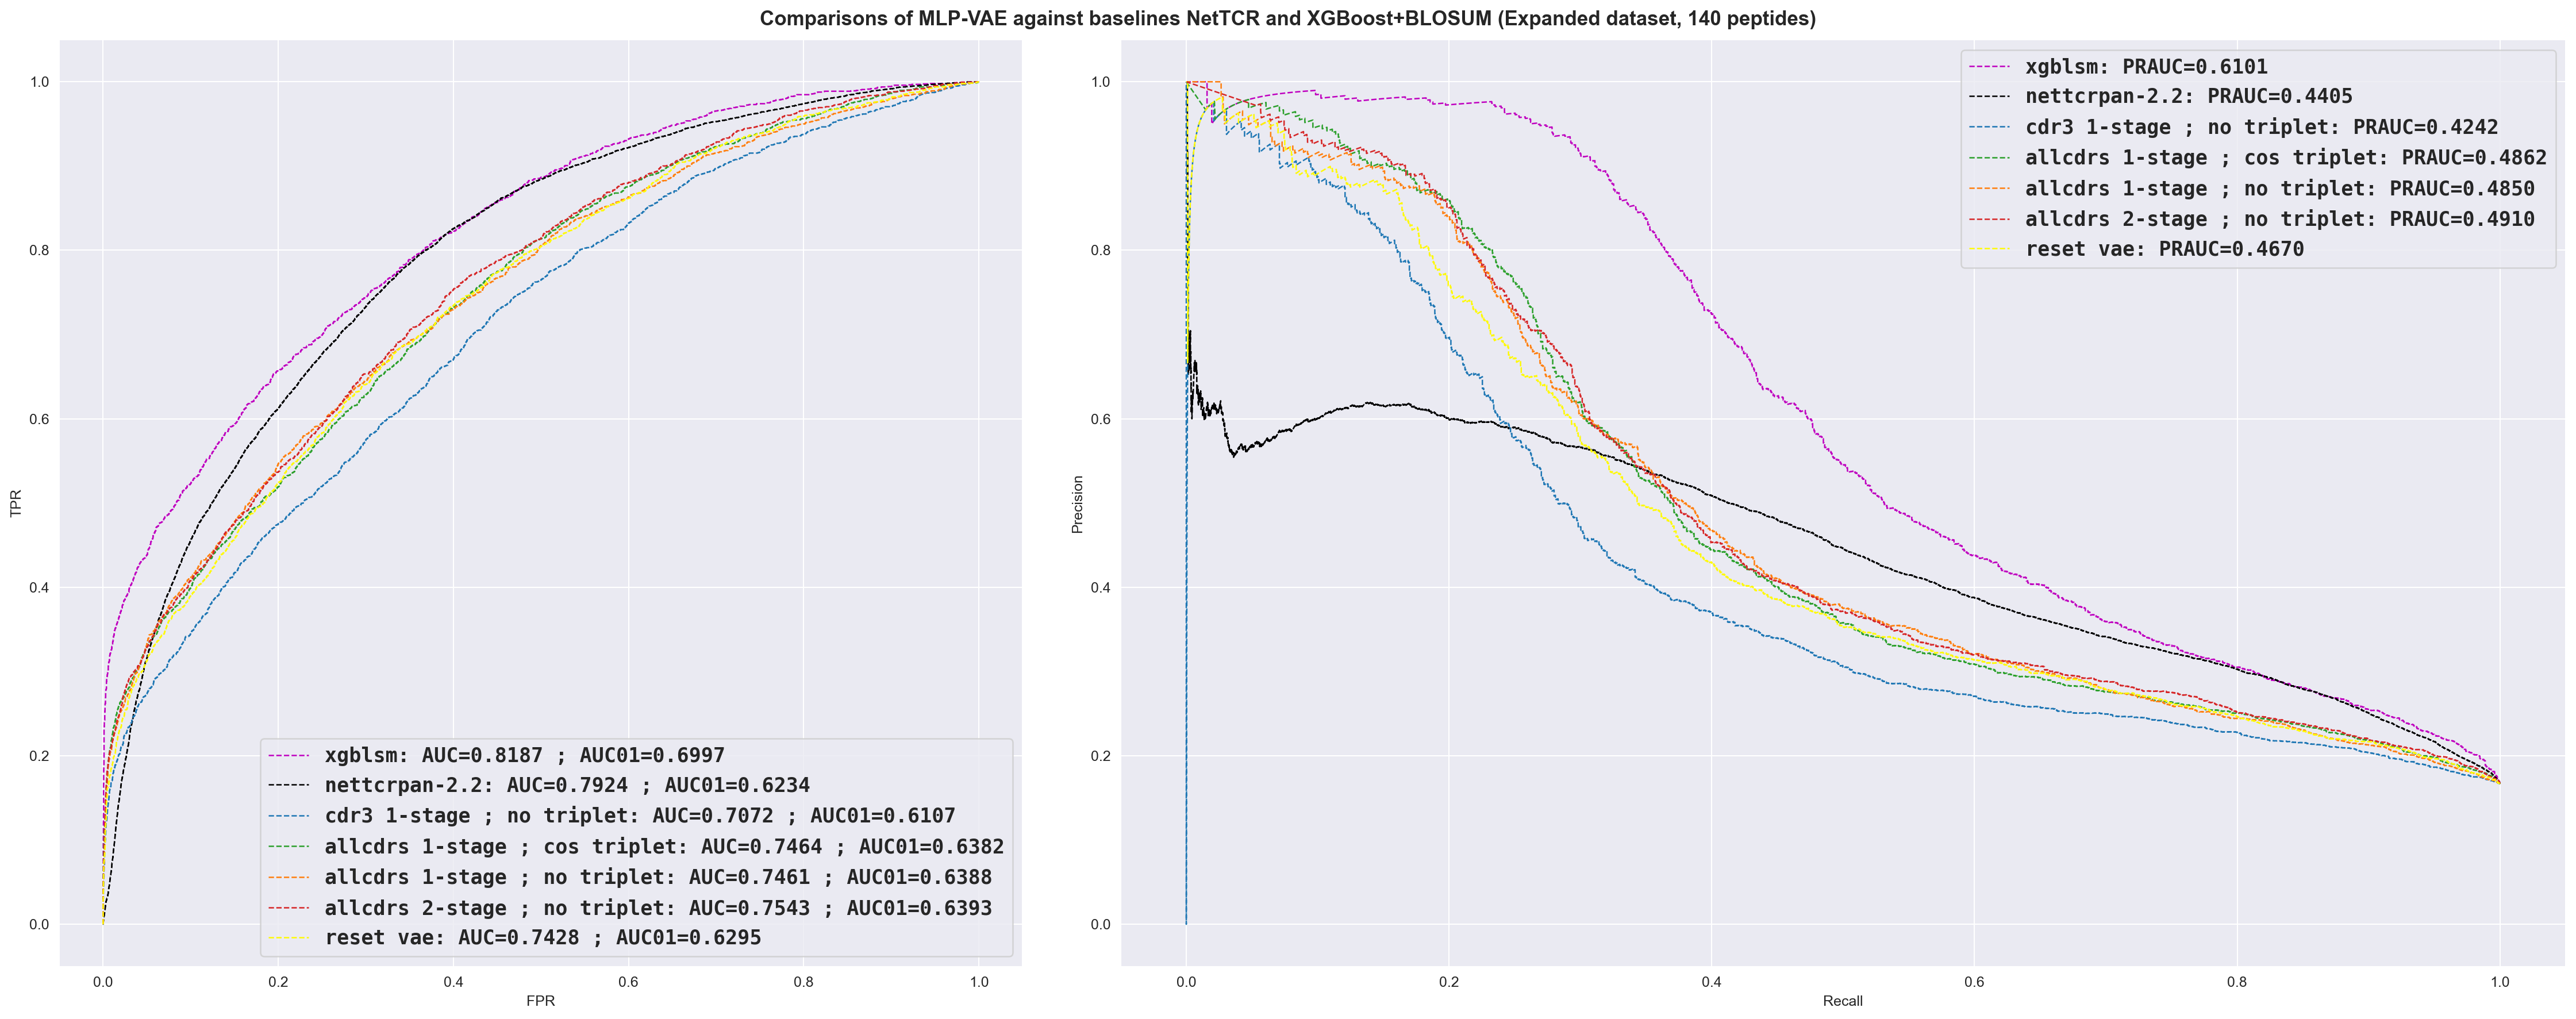

In [41]:
sns.set_palette('tab10', 7)
# f,a = plt.subplots(1,1, figsize=(20,10))
# Define the width ratios for the subplots
width_ratios = [2, 3]

# Create subplots with 1 row and 2 columns, using width_ratios for sizing
fig, ax = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': width_ratios})
ax = ax.ravel()
for k,v in new_comp.items():
    roc = v['roc_curve']
    pr = v['pr_curve']
    auc=v['auc']
    auc01=v['auc_01']
    prauc=v['prauc']
    
    ax[0].plot(roc[0], roc[1], label=f"{k.replace('_',' ').lower()}: AUC={auc:.4f} ; AUC01={auc01:.4f}", c= cdict[k], ls='--', lw=1)
    ax[1].plot(pr[0], pr[1], label=f"{k.replace('_',' ').lower()}: PRAUC={prauc:.4f}", c= cdict[k], ls='--', lw=1)
l1 = ax[0].legend(prop={'weight':'semibold','size':14, 'family':'monospace'})
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')

l2 = ax[1].legend(prop={'weight':'semibold','size':14, 'family':'monospace'})
fig.suptitle('Comparisons of MLP-VAE against baselines NetTCR and XGBoost+BLOSUM (Expanded dataset, 140 peptides)', fontweight='semibold', fontsize=14)
fig.tight_layout()

Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing


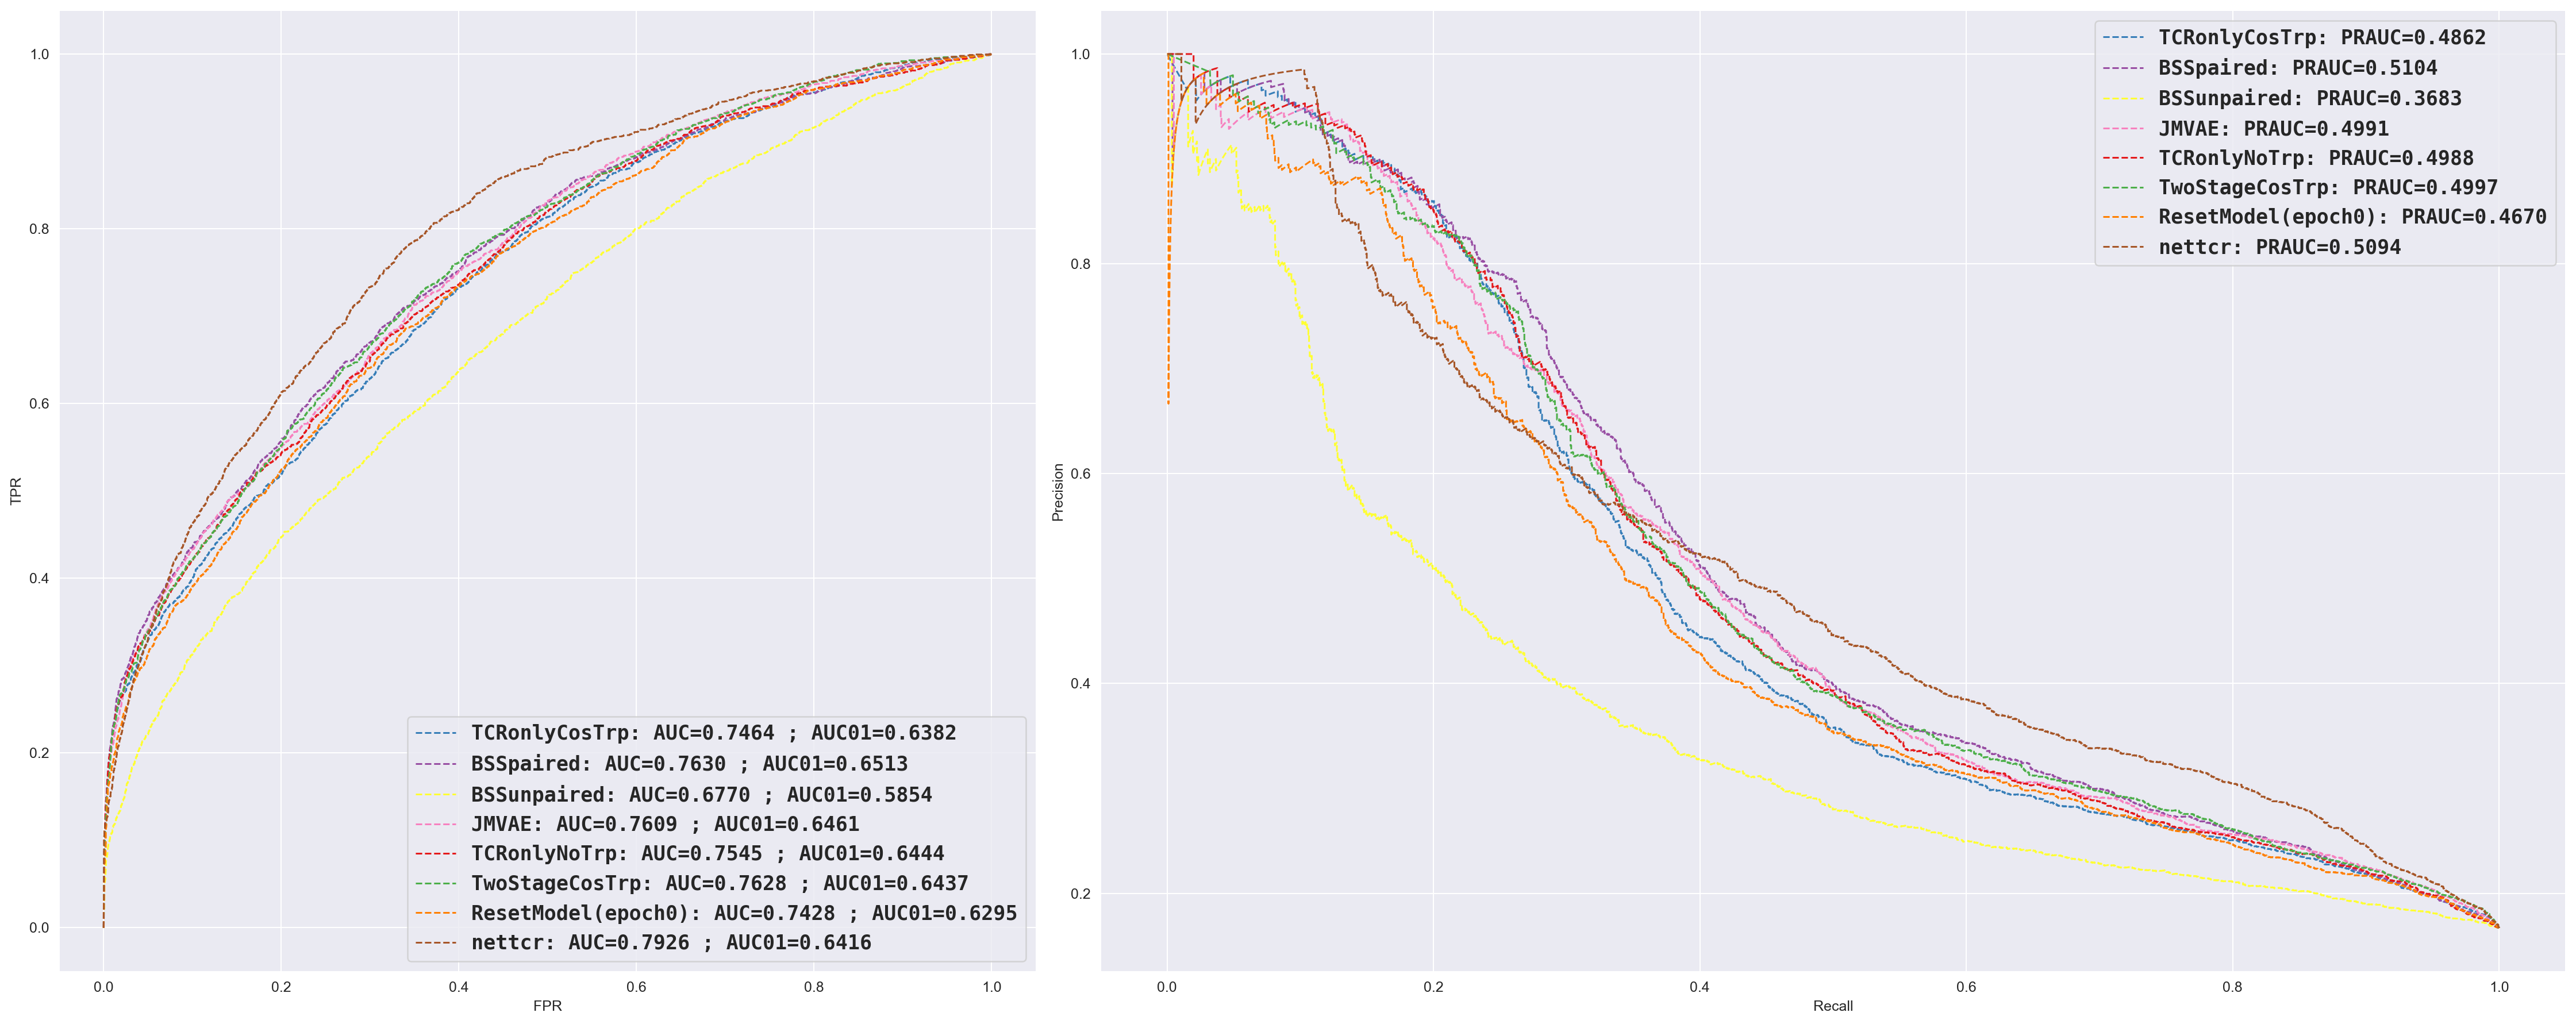

In [8]:
from src.metrics import get_metrics
fs = sorted(glob.glob('../output/240402_clf_logs_sorting/results_sorting/*/*pred*.csv'))
preds = {k.replace('../output/240402_clf_logs_sorting/results_sorting/','').split('/')[0]:get_metrics(pd.read_csv(k).query('partition==0')['binder'], 
                                                                                                      pd.read_csv(k).query('partition==0')['pred_prob'], 
                                                                                                      no_curves=False, reduced=False,
                                                                                                      round_digit=6)\
                                                                                                      for k in fs}
preds['nettcr'] = get_metrics(ntcr.query('partition==0')['binder'], ntcr.query('partition==0')['prediction'],no_curves=False, reduced=False,
                                                                                                      round_digit=4)
sns.set_palette(get_palette('Set1', len(preds)))
# f,a = plt.subplots(1,1, figsize=(20,10))
# Define the width ratios for the subplots
width_ratios = [2, 3]

# Create subplots with 1 row and 2 columns, using width_ratios for sizing
fig, ax = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': width_ratios})
ax = ax.ravel()
for k,v in preds.items():
    roc = v['roc_curve']
    pr = v['pr_curve']
    auc=v['auc']
    auc01=v['auc_01']
    prauc=v['prauc']
    ax[0].plot(roc[0], roc[1], label=f'{k.replace("PEPBLSM","").split("_")[-1]}: AUC={auc:.4f} ; AUC01={auc01:.4f}', ls='--', lw=1.2)
    ax[1].plot(pr[0], pr[1], label=f'{k.replace("PEPBLSM","").split("_")[-1]}: PRAUC={prauc:.4f}', ls='--', lw=1.2)
l1 = ax[0].legend(prop={'weight':'semibold','size':14, 'family':'monospace'})
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')

l2 = ax[1].legend(prop={'weight':'semibold','size':14, 'family':'monospace'})


fig.tight_layout()